In [2]:
#.............................................
# IMPORT STATEMENTS
#.............................................

# local env is py310

#Handling data
import numpy as np
import netCDF4 as nc
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

#machine learning package
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow import keras
from keras import layers
from tensorflow.keras import layers, Model

import numpy as np

from tensorflow.keras import layers, Sequential, Input, Model


from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, LeakyReLU, Flatten, Dense, Reshape, TimeDistributed, LSTM, ConvLSTM2D, Cropping2D
from tensorflow.keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

from netCDF4 import Dataset
import os


2.14.0
Num GPUs Available:  0


In [2]:

# Function to process each NetCDF file
def process_file(file_path):
    # Open the NetCDF file
    nc_file = Dataset(file_path, mode='r')

    # Extract the variable (e.g., 'pr') and its data
    precip_data = nc_file.variables['pr'][:] * 3600

    #normalized_data = smooth_normalize(precip_data)
    #standardized_data = standardize(precip_data)



    # Close the NetCDF file
    nc_file.close()

    return precip_data

# Path to the directory containing NetCDF files
directory_path = 'C:/Users/hebam/OneDrive - University of Calgary/Mitacs/data/Orig_all/'

# List to store the reshaped data
all_reshaped_data = []

# Loop through each file in the directory
for file_name in os.listdir(directory_path):
    if file_name.endswith('.nc'):  # Check for .nc files
        file_path = os.path.join(directory_path, file_name)  # Create full file path
        reshaped_data = process_file(file_path)
        all_reshaped_data.append(reshaped_data)

# Convert the list to a NumPy array for easier manipulation if needed
all_reshaped_data = np.array(all_reshaped_data)

# Check the shape of the combined data
print(f"Combined data shape: {all_reshaped_data.shape}")

# Transpose the dimensions from (10, 24, 26, 54) to (10, 24, 54, 26) if needed
# transposed_data = np.transpose(all_reshaped_data, (0, 1, 3, 2))

# Check the new shape if transposed
# print(f"Transposed data shape: {transposed_data.shape}")

y_train1 = all_reshaped_data
y_train = np.expand_dims(y_train1, axis=-1)

print(y_train.shape)


#The upscaled data
# Path to the directory containing NetCDF files
directory_path1 = 'C:/Users/hebam/OneDrive - University of Calgary/Mitacs/data/Up_all/'

# List to store the reshaped data
all_reshaped_data1 = []

# Loop through each file in the directory
for file_name in os.listdir(directory_path1):
    if file_name.endswith('.nc'):  # Check for .nc files
        file_path = os.path.join(directory_path1, file_name)  # Create full file path
        reshaped_data = process_file(file_path)
        all_reshaped_data1.append(reshaped_data)

# Convert the list to a NumPy array for easier manipulation if needed
all_reshaped_data1 = np.array(all_reshaped_data1)

# Check the shape of the combined data
print(f"Combined data shape: {all_reshaped_data1.shape}")

# Transpose the dimensions from (10, 24, 26, 54) to (10, 24, 54, 26) if needed
# transposed_data1 = np.transpose(all_reshaped_data1, (0, 1, 3, 2))

# Check the new shape if transposed
# print(f"Transposed data shape: {transposed_data1.shape}")

x_train1 = all_reshaped_data1
x_train = np.expand_dims(x_train1, axis=-1)

print(x_train.shape)



Combined data shape: (20416, 24, 26, 54)
(20416, 24, 26, 54, 1)
Combined data shape: (20416, 24, 7, 14)
(20416, 24, 7, 14, 1)


In [3]:
RF_highres = y_train
RF_lowres = x_train

In [4]:
#.............................................
# DATA SPLIT 
#.............................................




# Split dataset into training set, validation set and testing set 
#Xtrain=RF_lowres #training
#Ytrain=RF_highres
Xtrain=RF_lowres[0:13200] #training
Ytrain=RF_highres[0:13200]

#Xtrain=RF_lowres[0:2400] #training
#Ytrain=RF_highres[0:2400]
Xval=RF_lowres[13200:13611] #validation
Yval=RF_highres[13200:13611]
Xtest=RF_lowres[13611:20416] #validation
Ytest=RF_highres[13611:20416]


print(Xtrain.shape)



(13200, 24, 7, 14, 1)


In [5]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np

# Define the extracted hex colors
hex_colors = ["#ffffff",
"#f7f6f5",
"#ece8e5",
"#d0b5ae",
"#b78b81",
"#a56f67",
"#965c57",
"#864d4b",
"#773f42",
"#693139",
"#592631",
"#4a1c2c",
"#391a3c",
"#32215b",
"#4943a0",
"#5054ae",
"#485486",
"#4c6083",
"#54708d",
"#6a8da3",
"#85aab7",
"#c3b799",
"#edb376",
"#e98a4a",
"#e3662e",
"#d83e1d",
"#c5281a",
"#ac1b1e",
"#961a24",
"#831b2b"]  # Full list from above

# Create a colormap from the hex colors
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", hex_colors)


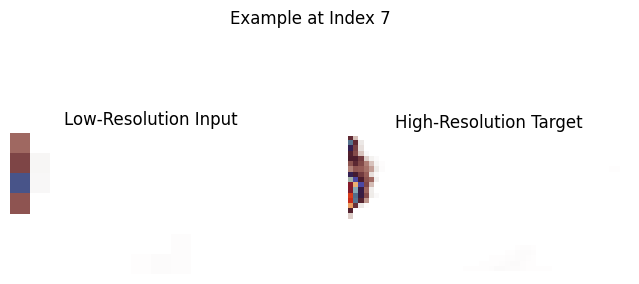

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_example(x_train, y_train, index):
    """
    Plots a specific example from the training data, including:
    - Low-resolution input
    - High-resolution target
    
    Parameters:
    - x_train: Low-resolution input data
    - y_train: High-resolution target data
    - index: Index of the sample to plot
    """
    
    # Determine color limits based on the high-resolution target for consistency
    vmin = np.min(y_train[index, 0, :, :, 0])
    vmax = np.max(y_train[index, 0, :, :, 0])

    # Plot low-resolution input and high-resolution target
    plt.figure(figsize=(8, 4))
    
    # Low-resolution input
    plt.subplot(1, 2, 1)
    plt.imshow(x_train[index, 0, :, :, 0], cmap=custom_cmap, vmin=vmin, vmax=vmax)
    plt.title("Low-Resolution Input")
    plt.axis("off")
    
    # High-resolution target
    plt.subplot(1, 2, 2)
    plt.imshow(y_train[index, 0, :, :, 0], cmap=custom_cmap, vmin=vmin, vmax=vmax)
    plt.title("High-Resolution Target")
    plt.axis("off")
    
    
    plt.suptitle(f"Example at Index {index}")
    plt.show()

# Example usage:
plot_example(Xtrain, Ytrain, index=7)


In [6]:
#.............................................
# DEFINE LOW/HIGH RES SIZE
#.............................................
LR_shape=np.shape(RF_lowres[0])
HR_shape=np.shape(RF_highres[0])

In [10]:
def generator_fit(x_train, x_val, y_train, y_val, input_shape=(24, 7, 14, 1), noise_shape=(7, 14, 1), 
                  output_shape=(24, 26, 54, 1), BATCH_SIZE=32, LEARNING_RATE=0.001, NUM_EPOCHS=100, 
                  PATIENCE=30, VERBOSITY=1, l2_reg=0.001):
    """
    Function to create, train, and evaluate a generator model with your custom callbacks for visualization and logging.
    """
    import tensorflow as tf
    from tensorflow.keras import layers, Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, Callback
    import time
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from tensorflow.keras.layers import Layer

    # Leaky ReLU with slope function
    def leaky_relu_with_slope(x):
        return layers.LeakyReLU(alpha=0.2)(x)

    # Reflection Padding function
    class ReflectionPadding2D(Layer):
        def __init__(self, padding=(1, 1), **kwargs):
            super().__init__(**kwargs)
            self.padding = padding

        def call(self, inputs):
            return tf.pad(
                inputs,
                [[0, 0], [self.padding[0], self.padding[0]], [self.padding[1], self.padding[1]], [0, 0]],
                mode="REFLECT"
            )
    # Residual Block function with L2 regularization
    def residual_block(x, filters, kernel_size=3, stride=1, padding='same', l2_reg=0.001):
        shortcut = x
        x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding=padding, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(shortcut)
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    # Define the generator model
    def make_generator(input_shape, noise_shape, output_shape):
        low_res_input = layers.Input(shape=input_shape, name='low_res_input')
        noise_input = layers.Input(shape=noise_shape, name='noise_input')

        noise_embedding = layers.Dense(16, activation='relu')(noise_input)
        shared_noise_repeated = tf.repeat(tf.expand_dims(noise_embedding, axis=1), repeats=input_shape[0], axis=1)

        x_init = layers.TimeDistributed(layers.Conv2D(16, kernel_size=3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)))(low_res_input)
        x_init = layers.Activation('relu')(x_init)
        x_init_first_step = x_init[:, 0]
        x_init = layers.Concatenate(axis=-1)([x_init_first_step, noise_input])
        x_init = residual_block(x_init, filters=16)

        init_state = layers.Conv2D(16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x_init)

        x_update = []
        for t in range(input_shape[0]):
            x_t = layers.TimeDistributed(layers.Conv2D(16, kernel_size=3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)))(low_res_input)[:, t]
            x_t = layers.Activation('relu')(x_t)
            x_t = layers.Concatenate(axis=-1)([x_t, shared_noise_repeated[:, t]])
            x_t = residual_block(x_t, filters=16)
            x_update.append(x_t)

        x_update = tf.stack(x_update, axis=1)
        x_update = layers.ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu')(x_update, initial_state=[init_state, init_state])

        x_up = layers.TimeDistributed(layers.UpSampling2D(size=(2, 2), interpolation='bilinear'))(x_update)
        x_up = layers.TimeDistributed(ReflectionPadding2D(padding=(1, 1)))(x_up)
        x_up = layers.TimeDistributed(layers.Conv2D(32, kernel_size=3, padding='valid', kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x_up)
        x_up = leaky_relu_with_slope(x_up)
        x_up = residual_block(x_up, filters=32)

        x_up = layers.TimeDistributed(layers.UpSampling2D(size=(2, 2), interpolation='bilinear'))(x_up)
        x_up = layers.TimeDistributed(ReflectionPadding2D(padding=(1, 1)))(x_up)
        x_up = layers.TimeDistributed(layers.Conv2D(16, kernel_size=3, padding='valid', kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x_up)
        x_up = leaky_relu_with_slope(x_up)
        x_up = residual_block(x_up, filters=16)

        x_up = layers.TimeDistributed(layers.Conv2D(1, kernel_size=3, padding='same', activation='linear'))(x_up)
        output = layers.TimeDistributed(layers.Cropping2D(cropping=((1, 1), (1, 1))))(x_up)

        model = Model(inputs=[low_res_input, noise_input], outputs=output, name='generator')
        model.summary()

        return model

    # Instantiate and compile the generator model
    generator = make_generator(input_shape, noise_shape, output_shape)
    optimizer = Adam(learning_rate=LEARNING_RATE)
    generator.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])

    # Callbacks
    class PrintEpochLoss(Callback):
        def on_epoch_end(self, epoch, logs=None):
            print(f"Epoch {epoch + 1}, Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}")

    class PlotEpochOutput(Callback):
        def __init__(self, model, x_train, y_train, noise_shape, cmap='viridis'):
            self.model = model
            self.x_train = x_train
            self.y_train = y_train
            self.noise_shape = noise_shape
            self.cmap = custom_cmap  # Use a valid colormap

        def on_epoch_end(self, epoch, logs=None):
            # Randomly select a sample index
            idx = np.random.randint(0, self.x_train.shape[0])
            
            # Prepare inputs
            low_res_input = np.expand_dims(self.x_train[idx], axis=0)
            noise_input = np.random.normal(0, 1, (1,) + self.noise_shape)
            
            # Generate model output
            generated_output = self.model.predict([low_res_input, noise_input])

            # Define the color scale limits based on the high-resolution target
            vmin = np.min(self.y_train[idx, 4, :, :, 0])
            vmax = np.max(self.y_train[idx, 4, :, :, 0])

            # Create a figure with subplots
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            # Plot Low-Resolution Input
            im0 = axs[0].imshow(self.x_train[idx, 4, :, :, 0], cmap=self.cmap, vmin=vmin, vmax=vmax)
            axs[0].set_title("Low-Resolution Input")
            axs[0].axis("off")

            # Plot High-Resolution Target
            im1 = axs[1].imshow(self.y_train[idx, 4, :, :, 0], cmap=self.cmap, vmin=vmin, vmax=vmax)
            axs[1].set_title("High-Resolution Target")
            axs[1].axis("off")

            # Plot Generated Output
            im2 = axs[2].imshow(generated_output[0, 4, :, :, 0], cmap=self.cmap, vmin=vmin, vmax=vmax)
            axs[2].set_title("Generated Output")
            axs[2].axis("off")

            # Add a horizontal color bar below the plots
            cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.03])  # [left, bottom, width, height]
            cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
            cbar.set_label("Intensity (e.g., mm/hr)")

            # Add a super title for the entire plot
            plt.suptitle(f"Epoch {epoch + 1}", fontsize=16)

            # Adjust layout and display the plot
            plt.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust layout to fit color bar and title
            plt.show()

    class CSVLoggerCallback(Callback):
        def __init__(self, filename="training_log.csv"):
            super().__init__()
            self.filename = filename
            self.logs = []

        def on_epoch_end(self, epoch, logs=None):
            self.logs.append({
                "epoch": epoch + 1,
                "loss": logs["loss"],
                "val_loss": logs["val_loss"]
            })

        def on_train_end(self, logs=None):
            df = pd.DataFrame(self.logs)
            df.to_csv(self.filename, index=False)
            print(f"Training and validation losses saved to {self.filename}")

    # Instantiate callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=VERBOSITY)
    print_epoch_loss = PrintEpochLoss()
    plot_epoch_output = PlotEpochOutput(generator, x_train, y_train, noise_shape)
    csv_logger = CSVLoggerCallback()

    # Train the model
    start_time = time.time()
    history = generator.fit(
        x=[x_train, np.random.normal(0, 1, (x_train.shape[0],) + noise_shape)],
        y=y_train,
        validation_data=([x_val, np.random.normal(0, 1, (x_val.shape[0],) + noise_shape)], y_val),
        batch_size=BATCH_SIZE,
        epochs=NUM_EPOCHS,
        shuffle=True,
        verbose=VERBOSITY,
        callbacks=[early_stopping, print_epoch_loss, plot_epoch_output, csv_logger]
    )
    end_time = time.time()
    print(f"Elapsed time: {(end_time - start_time) / 60:.2f} minutes")

    return generator, history


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 noise_input (InputLayer)    [(None, 7, 14, 1)]           0         []                            
                                                                                                  
 low_res_input (InputLayer)  [(None, 24, 7, 14, 1)]       0         []                            
                                                                                                  
 dense (Dense)               (None, 7, 14, 16)            32        ['noise_input[0][0]']         
                                                                                                  
 time_distributed_1 (TimeDi  (None, 24, 7, 14, 16)        160       ['low_res_input[0][0]']       
 stributed)                                                                               

C:\Users\hebam\AppData\Local\Temp\ipykernel_3648\1864909130.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust layout to fit color bar and title


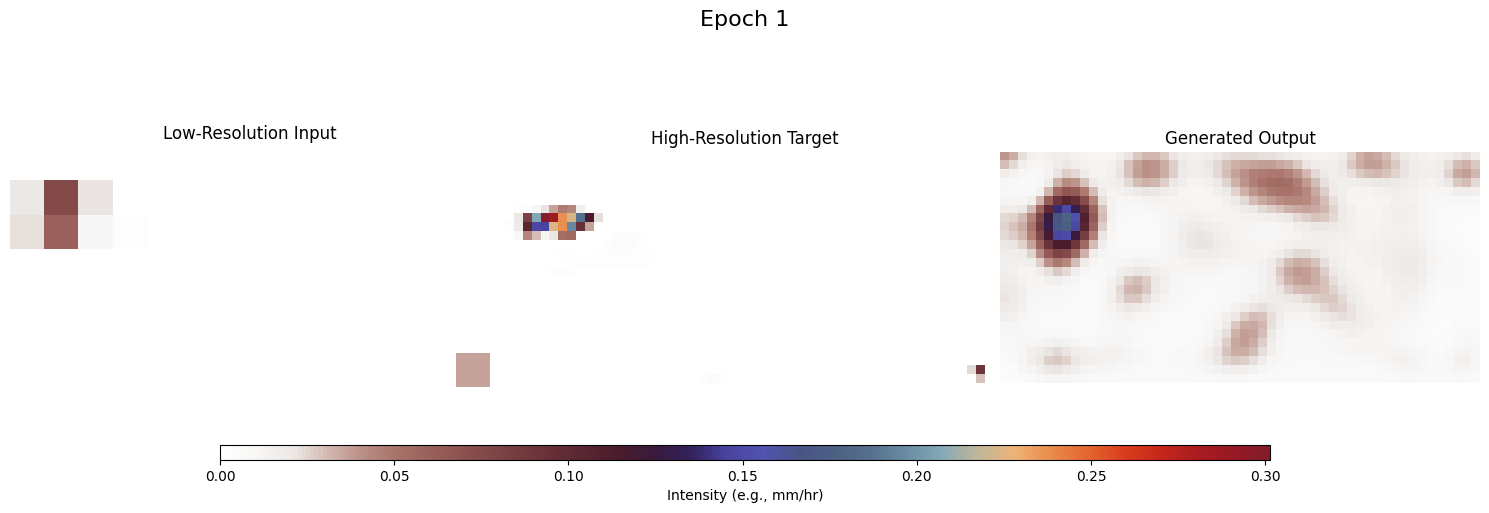

413/413 [==============================] - 2219s 5s/step - loss: 0.2966 - mean_absolute_error: 0.0573 - val_loss: 0.0393 - val_mean_absolute_error: 0.0417
Epoch 2/20
1/1 [==============================] - 0s 131ms/step


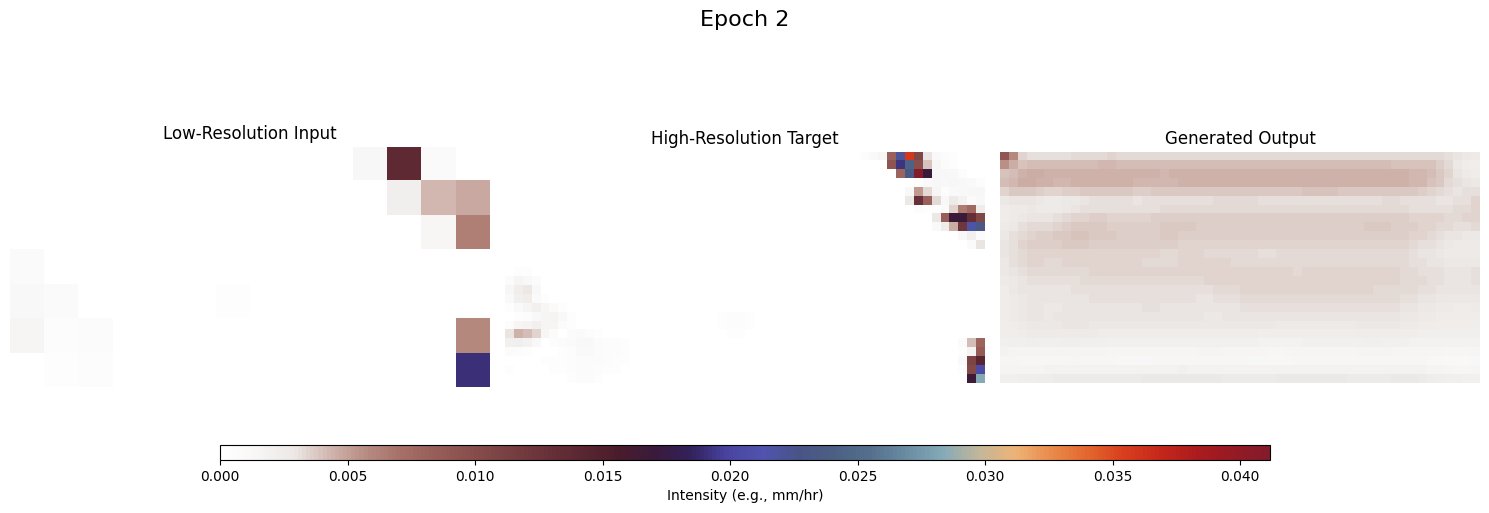

413/413 [==============================] - 1831s 4s/step - loss: 0.0341 - mean_absolute_error: 0.0420 - val_loss: 0.0275 - val_mean_absolute_error: 0.0360
Epoch 3/20
1/1 [==============================] - 0s 136ms/step


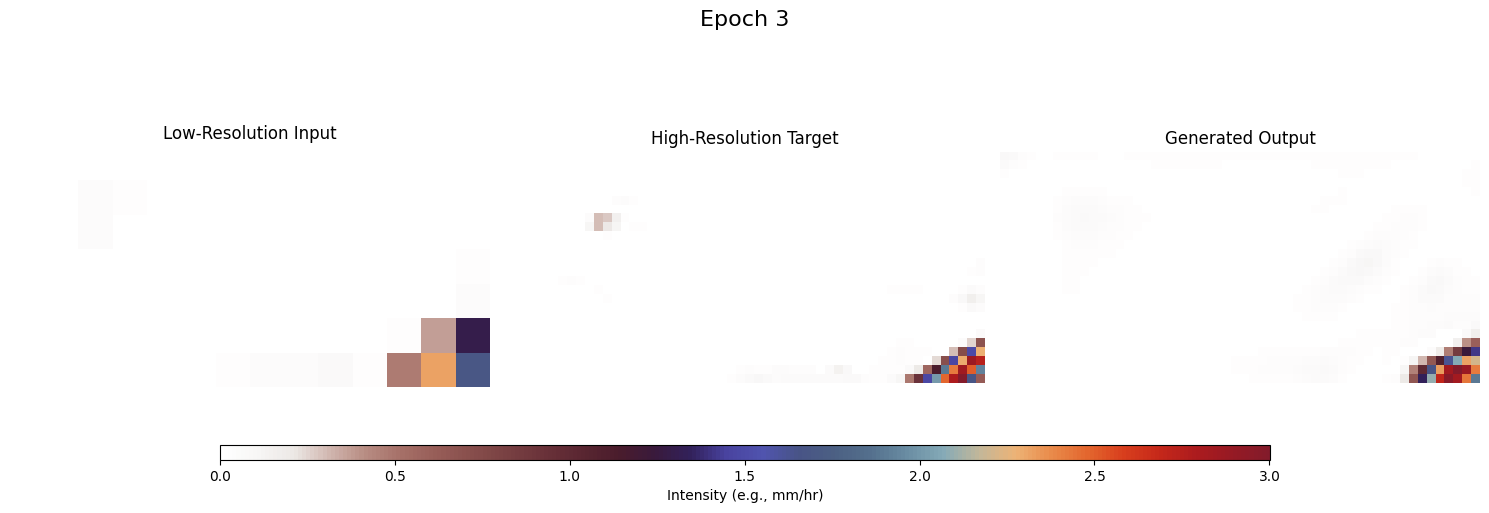

413/413 [==============================] - 1725s 4s/step - loss: 0.0293 - mean_absolute_error: 0.0409 - val_loss: 0.0243 - val_mean_absolute_error: 0.0349
Epoch 4/20
1/1 [==============================] - 0s 120ms/step


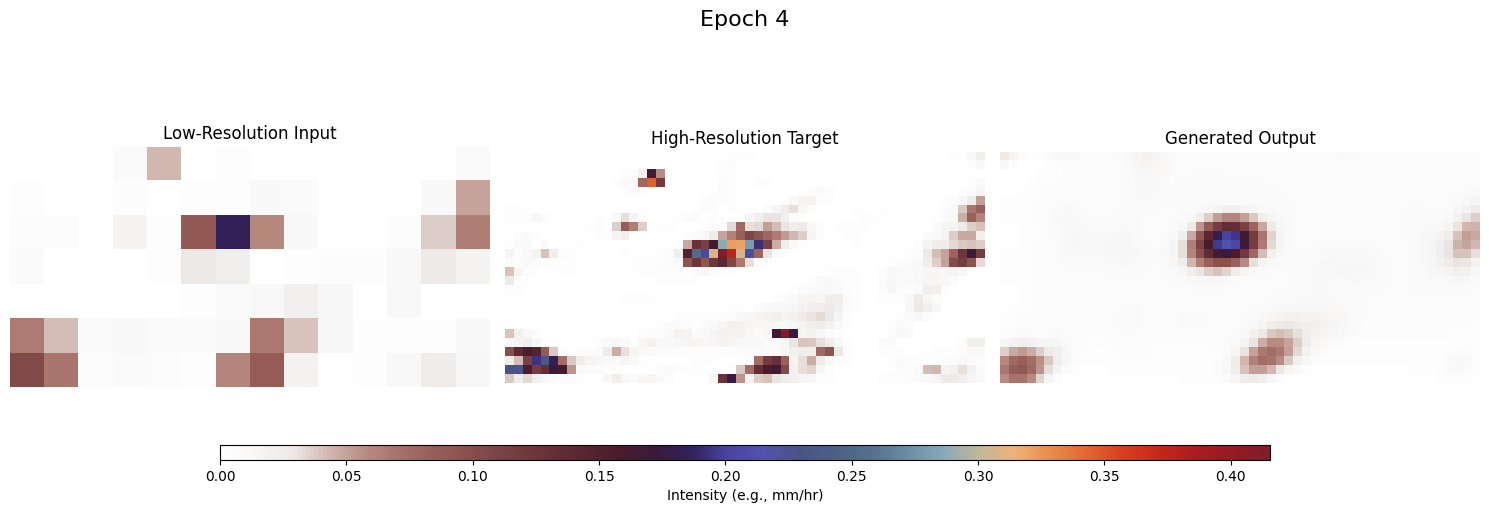

413/413 [==============================] - 1739s 4s/step - loss: 0.0290 - mean_absolute_error: 0.0412 - val_loss: 0.0241 - val_mean_absolute_error: 0.0336
Epoch 5/20
1/1 [==============================] - 0s 140ms/step


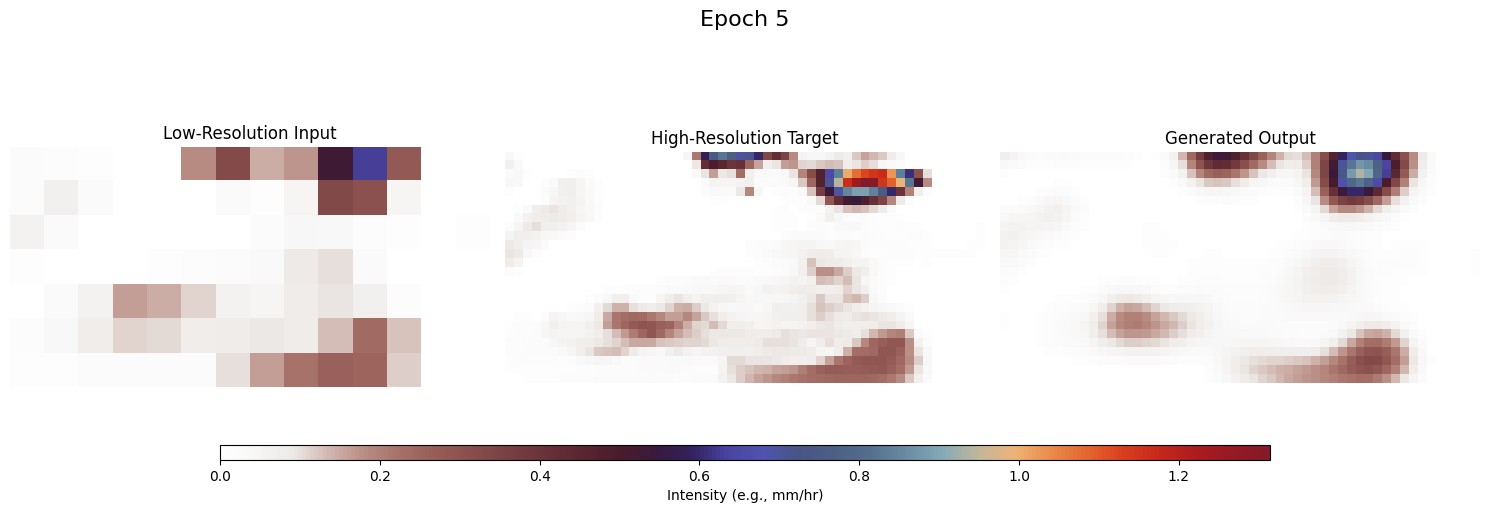

413/413 [==============================] - 1965s 5s/step - loss: 0.0260 - mean_absolute_error: 0.0369 - val_loss: 0.0223 - val_mean_absolute_error: 0.0324
Epoch 6/20
1/1 [==============================] - 0s 180ms/step


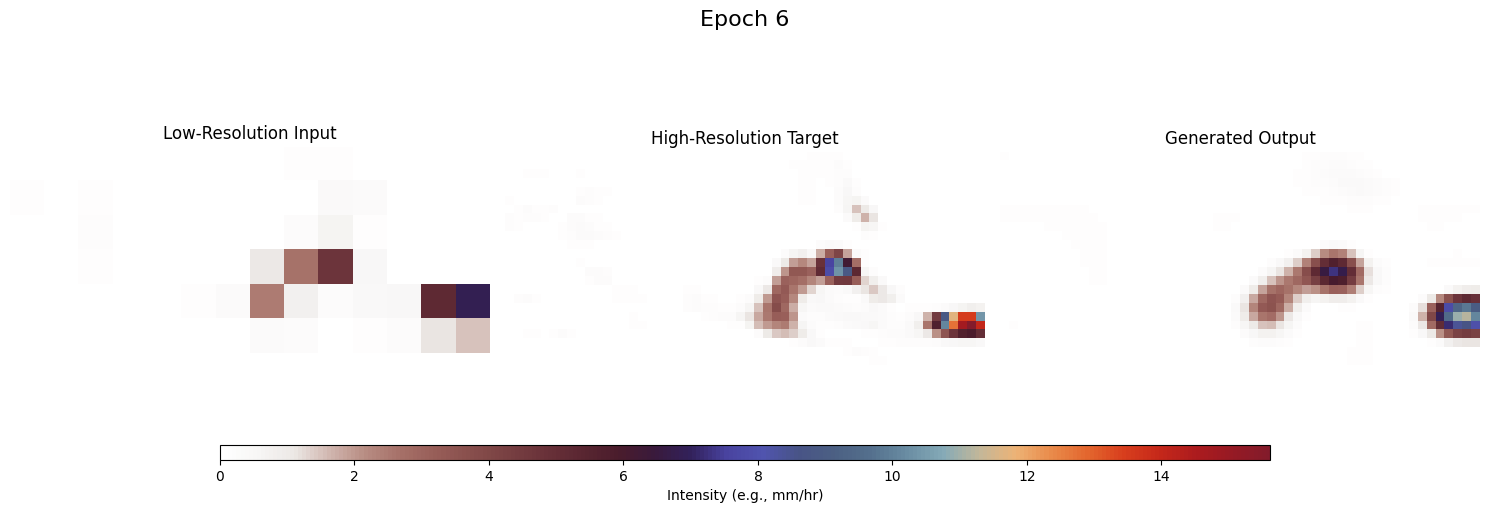

413/413 [==============================] - 2013s 5s/step - loss: 0.0254 - mean_absolute_error: 0.0374 - val_loss: 0.0217 - val_mean_absolute_error: 0.0323
Epoch 7/20
1/1 [==============================] - 0s 205ms/step


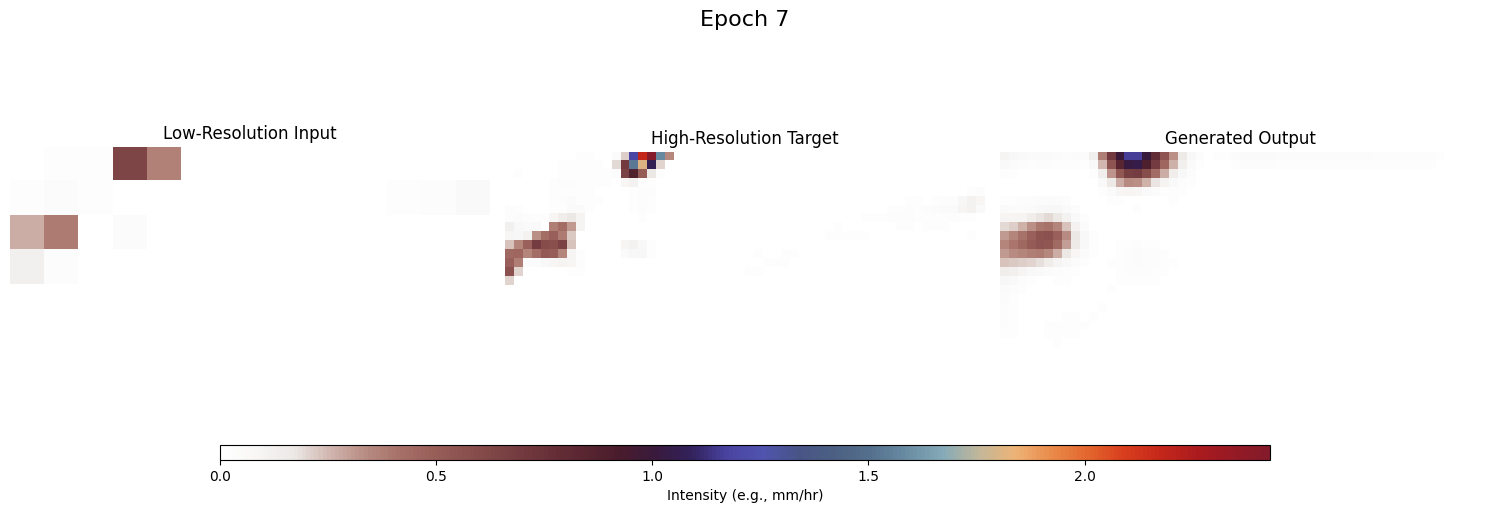

413/413 [==============================] - 2126s 5s/step - loss: 0.0246 - mean_absolute_error: 0.0368 - val_loss: 0.0210 - val_mean_absolute_error: 0.0340
Epoch 8/20
1/1 [==============================] - 0s 172ms/step


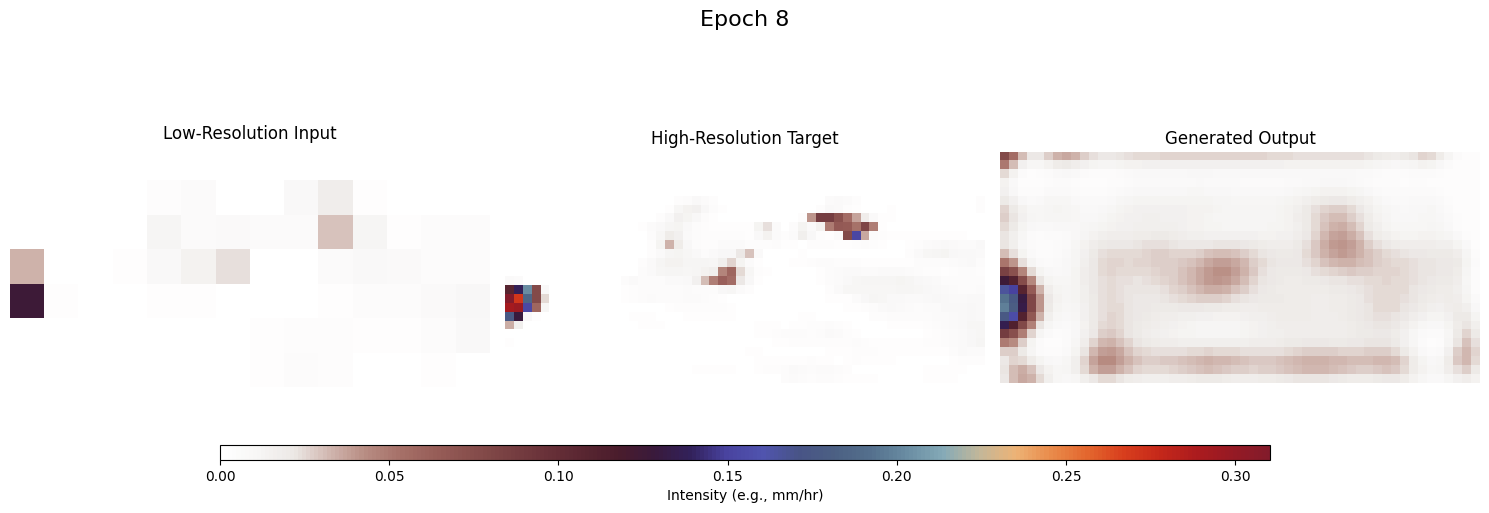

413/413 [==============================] - 2341s 6s/step - loss: 0.0239 - mean_absolute_error: 0.0361 - val_loss: 0.0210 - val_mean_absolute_error: 0.0351
Epoch 9/20
1/1 [==============================] - 0s 136ms/step


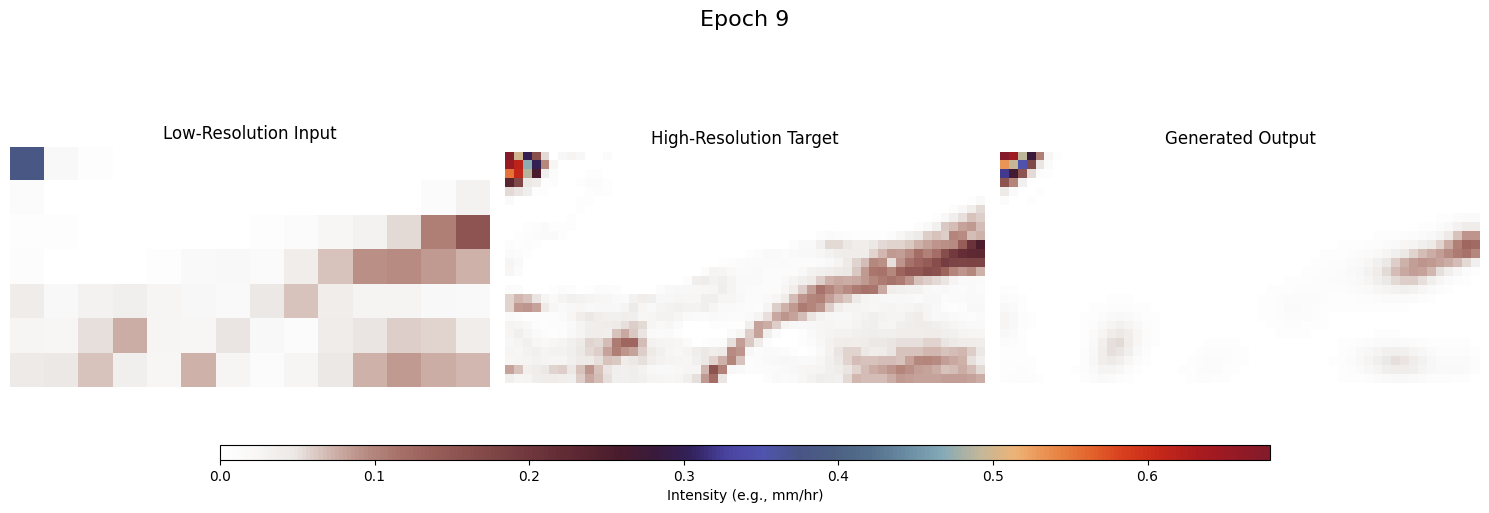

413/413 [==============================] - 2311s 6s/step - loss: 0.0234 - mean_absolute_error: 0.0359 - val_loss: 0.0211 - val_mean_absolute_error: 0.0321
Epoch 10/20
1/1 [==============================] - 0s 97ms/step


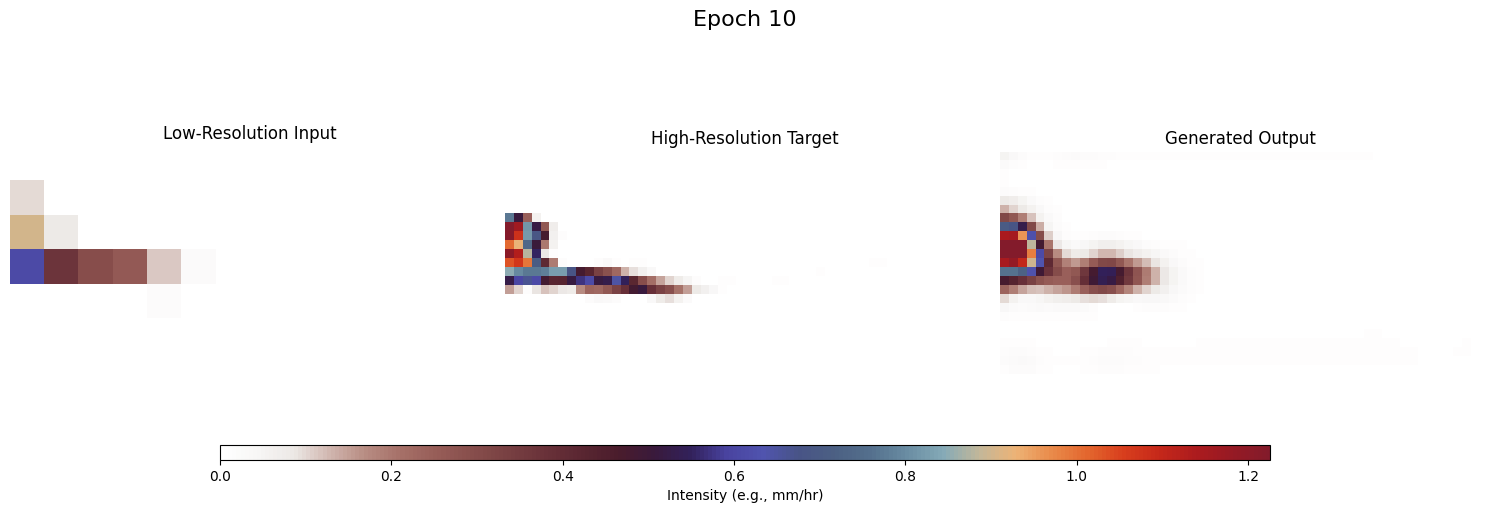

413/413 [==============================] - 2423s 6s/step - loss: 0.0239 - mean_absolute_error: 0.0365 - val_loss: 0.0199 - val_mean_absolute_error: 0.0334
Epoch 11/20
1/1 [==============================] - 0s 175ms/step


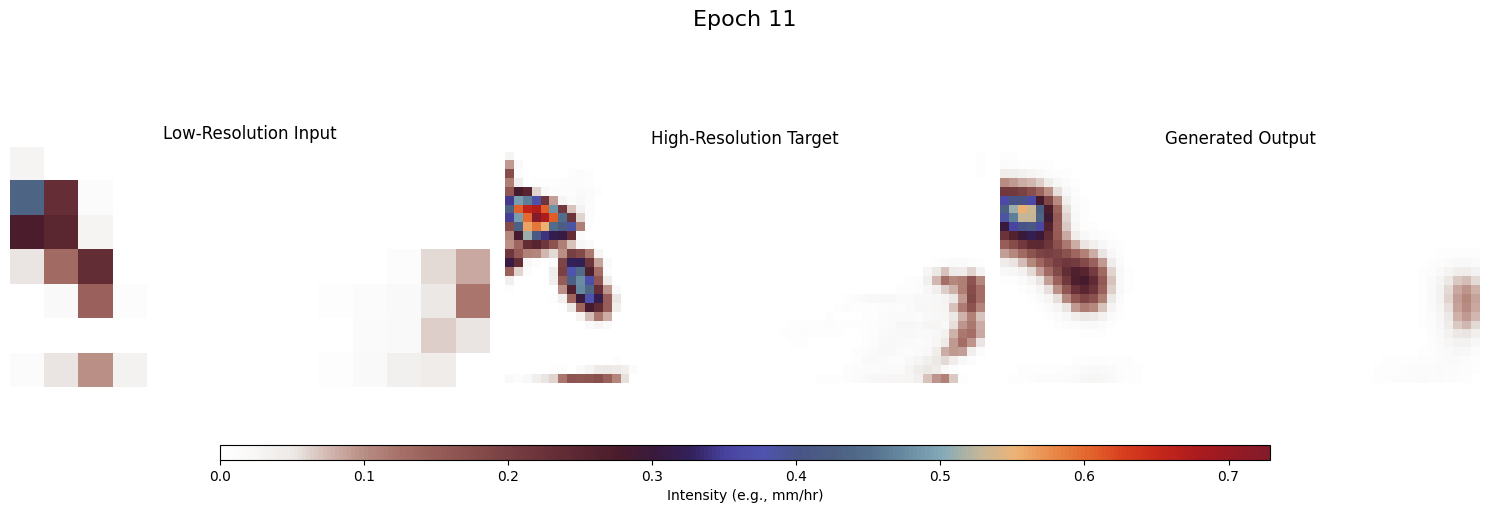

413/413 [==============================] - 1980s 5s/step - loss: 0.0231 - mean_absolute_error: 0.0364 - val_loss: 0.0198 - val_mean_absolute_error: 0.0310
Epoch 12/20
1/1 [==============================] - 0s 189ms/step


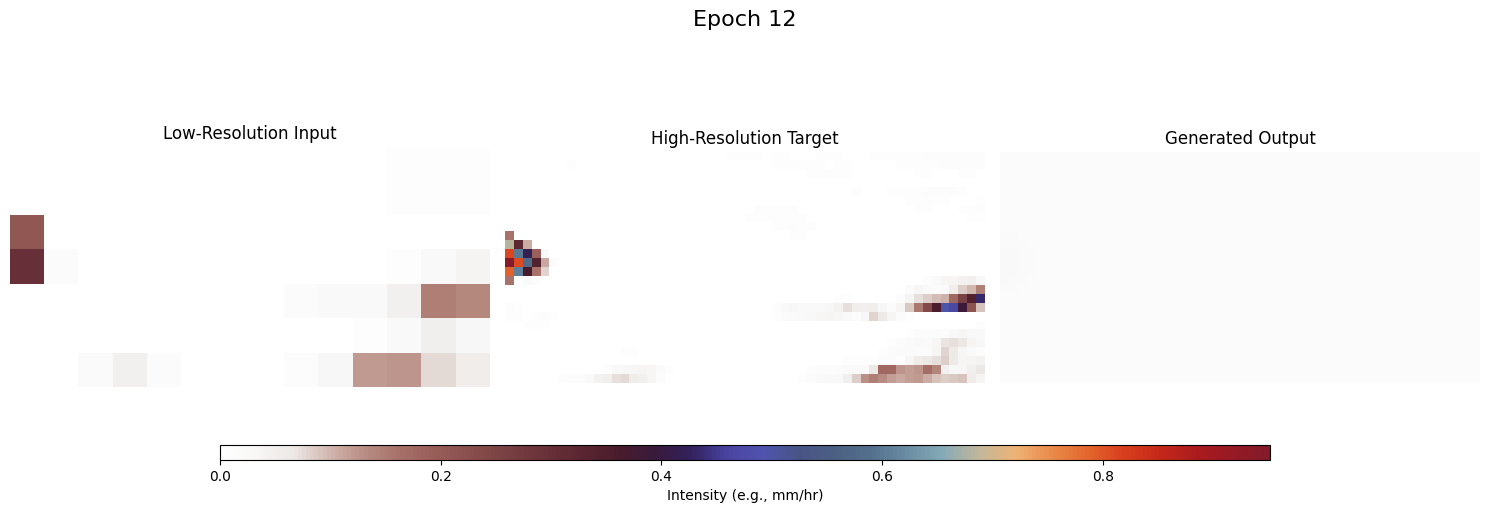

413/413 [==============================] - 1892s 5s/step - loss: 0.0226 - mean_absolute_error: 0.0355 - val_loss: 0.0245 - val_mean_absolute_error: 0.0435
Epoch 13/20
1/1 [==============================] - 0s 146ms/step


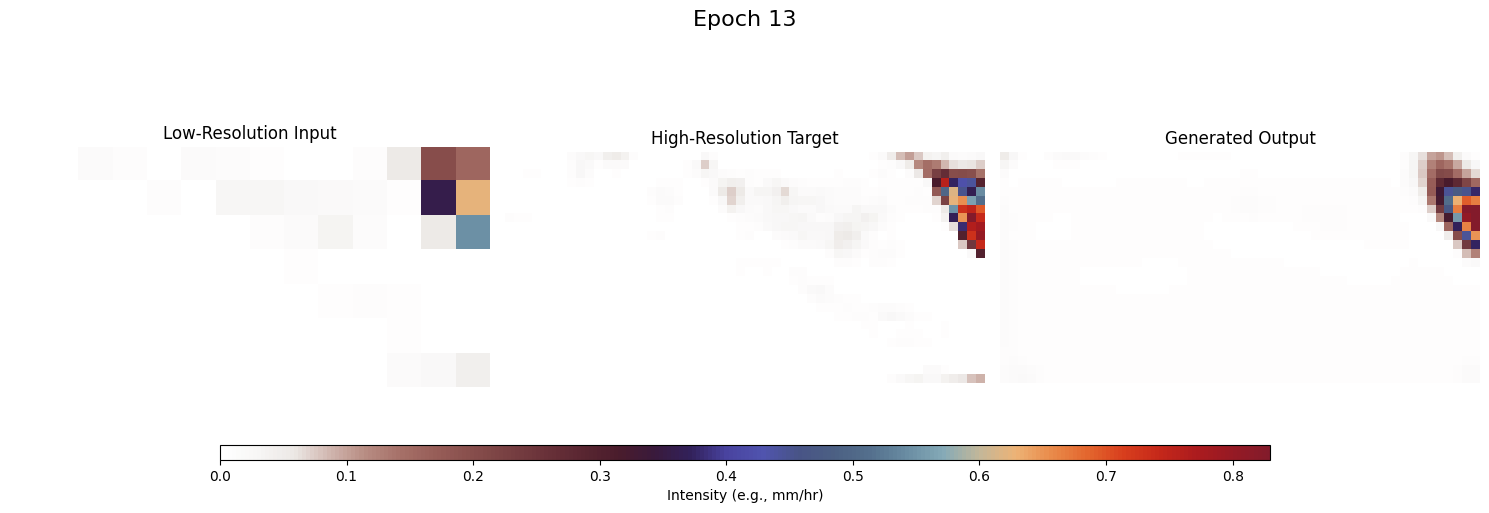

413/413 [==============================] - 2064s 5s/step - loss: 0.0220 - mean_absolute_error: 0.0346 - val_loss: 0.0189 - val_mean_absolute_error: 0.0308
Epoch 14/20
1/1 [==============================] - 0s 104ms/step


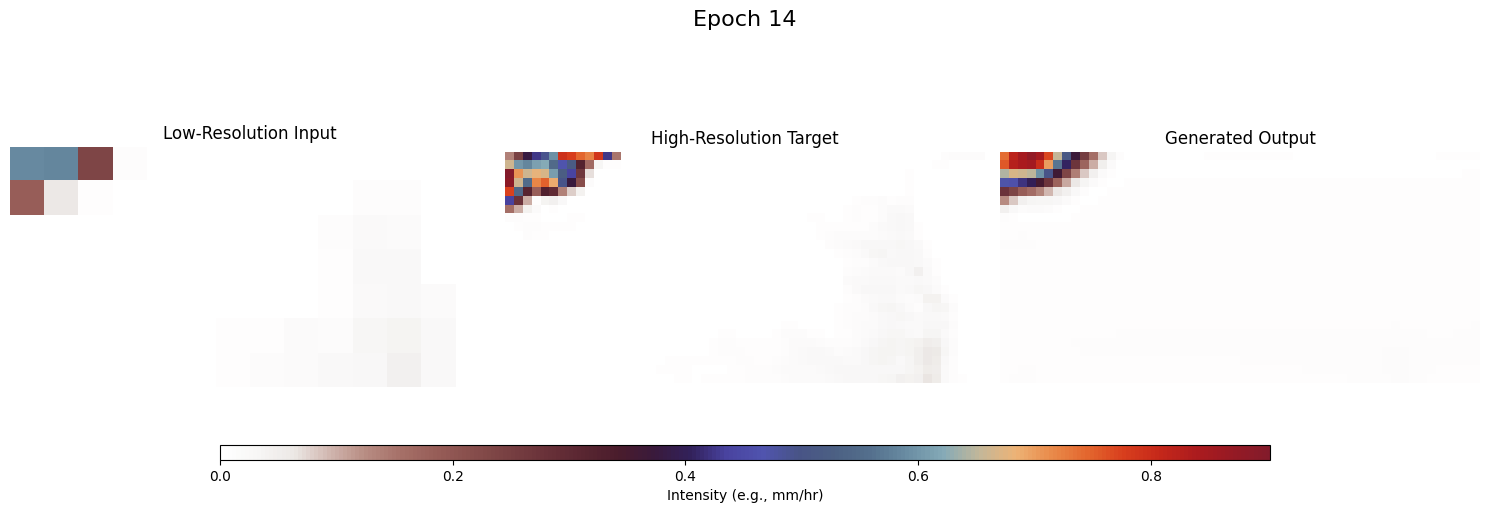

413/413 [==============================] - 2250s 5s/step - loss: 0.0216 - mean_absolute_error: 0.0349 - val_loss: 0.0198 - val_mean_absolute_error: 0.0335
Epoch 15/20
1/1 [==============================] - 0s 119ms/step


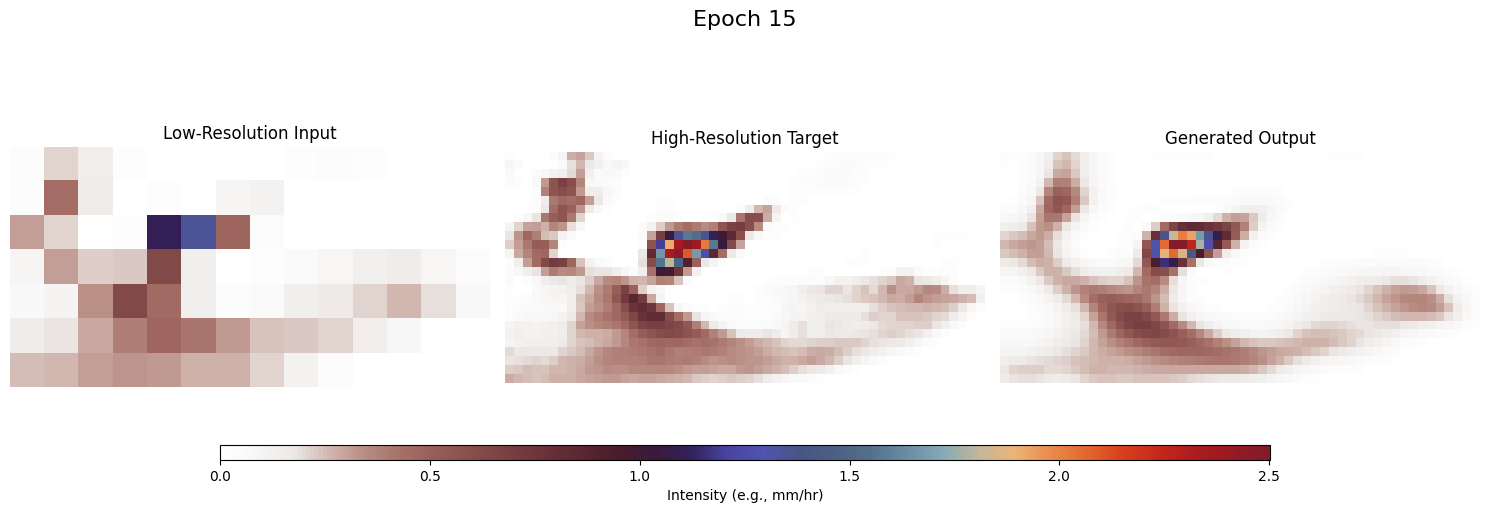

413/413 [==============================] - 2015s 5s/step - loss: 0.0216 - mean_absolute_error: 0.0352 - val_loss: 0.0184 - val_mean_absolute_error: 0.0305
Epoch 16/20
1/1 [==============================] - 0s 171ms/step


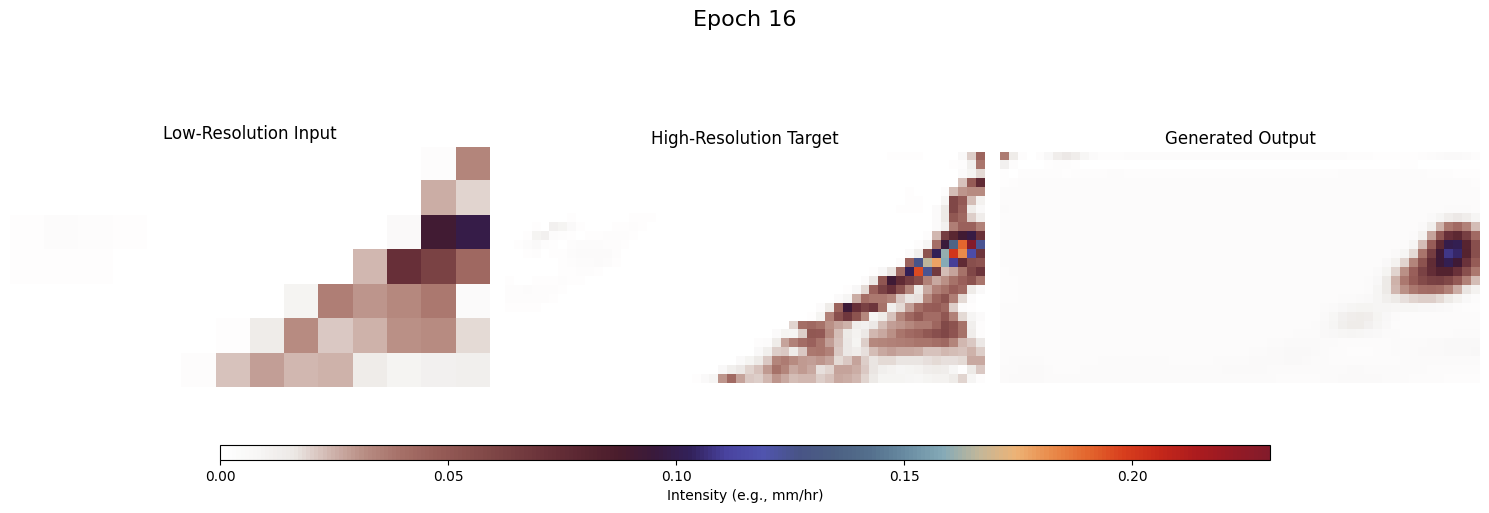

413/413 [==============================] - 1823s 4s/step - loss: 0.0220 - mean_absolute_error: 0.0359 - val_loss: 0.0185 - val_mean_absolute_error: 0.0305
Epoch 17/20
1/1 [==============================] - 0s 141ms/step


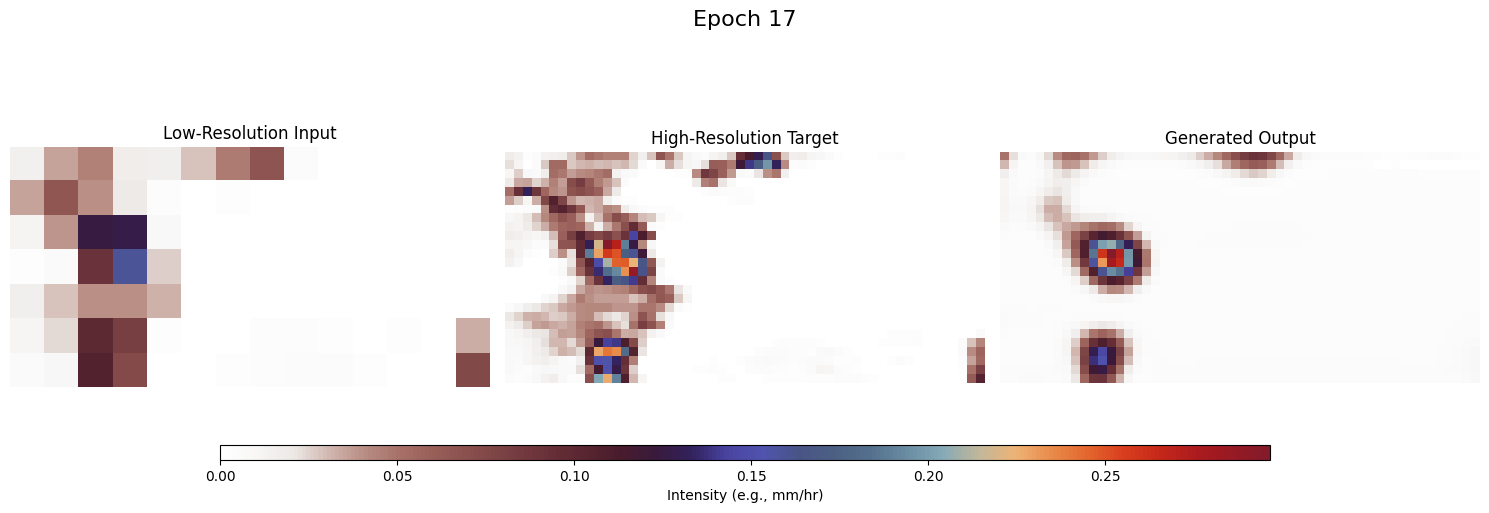

413/413 [==============================] - 1820s 4s/step - loss: 0.0208 - mean_absolute_error: 0.0338 - val_loss: 0.0182 - val_mean_absolute_error: 0.0307
Epoch 18/20
1/1 [==============================] - 0s 101ms/step


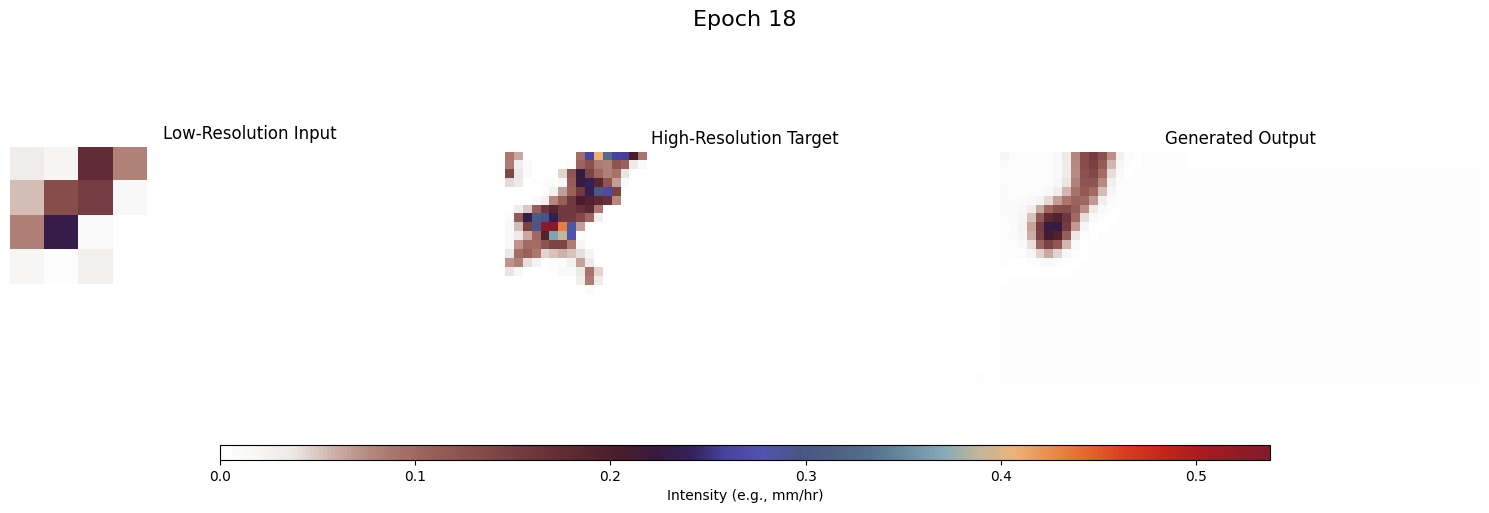

413/413 [==============================] - 1845s 4s/step - loss: 0.0208 - mean_absolute_error: 0.0346 - val_loss: 0.0184 - val_mean_absolute_error: 0.0307
Epoch 19/20
1/1 [==============================] - 0s 159ms/step


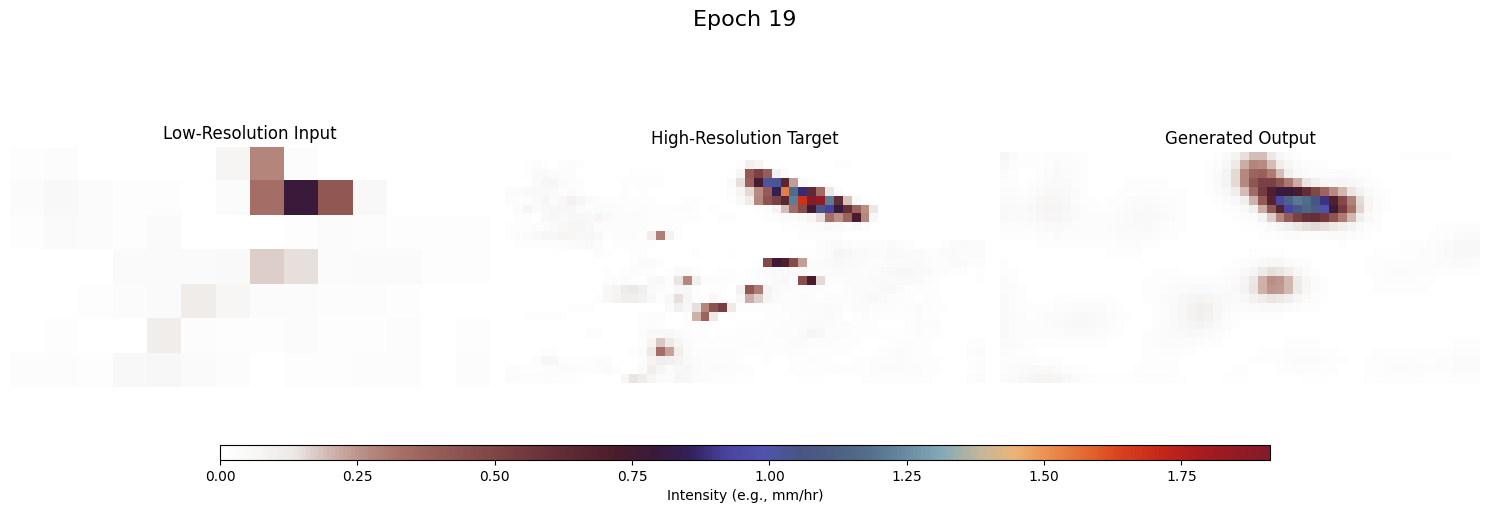

413/413 [==============================] - 1668s 4s/step - loss: 0.0211 - mean_absolute_error: 0.0354 - val_loss: 0.0186 - val_mean_absolute_error: 0.0345
Epoch 20/20
1/1 [==============================] - 0s 66ms/step


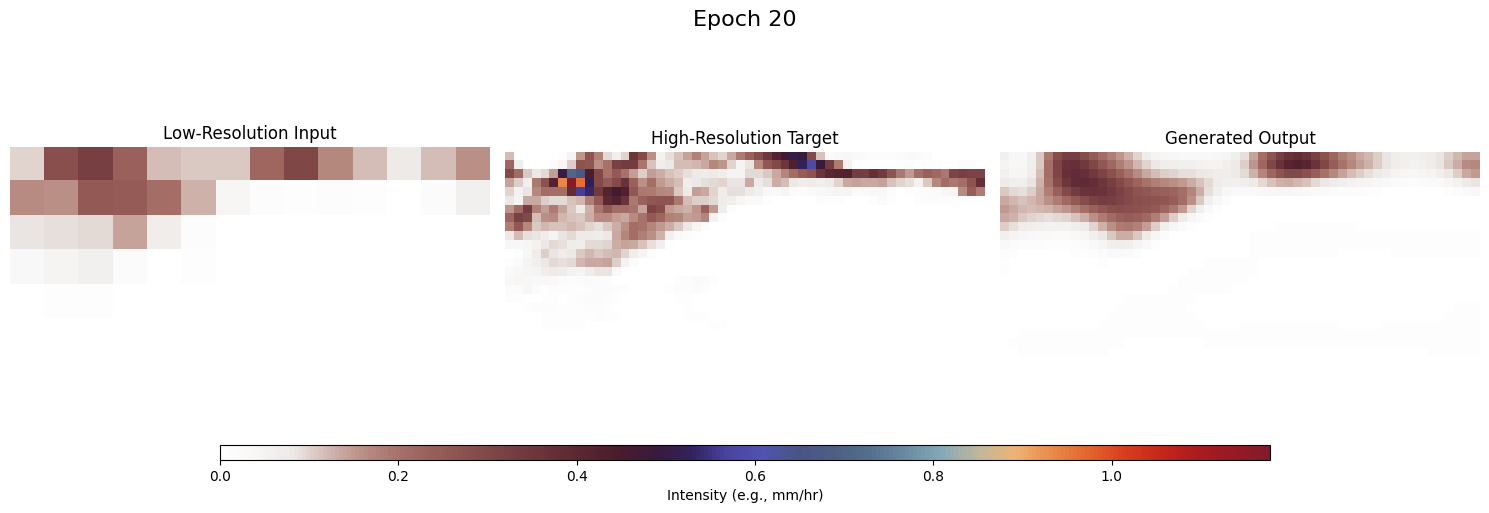

413/413 [==============================] - 1958s 5s/step - loss: 0.0205 - mean_absolute_error: 0.0340 - val_loss: 0.0178 - val_mean_absolute_error: 0.0305
Training and validation losses saved to training_log.csv
Elapsed time: 666.86 minutes


In [11]:
# Use the function to train the generator
model, history = generator_fit(
    Xtrain, Xval, Ytrain, Yval, 
    BATCH_SIZE=32, LEARNING_RATE=0.001, NUM_EPOCHS=20, PATIENCE=30, VERBOSITY=1
)

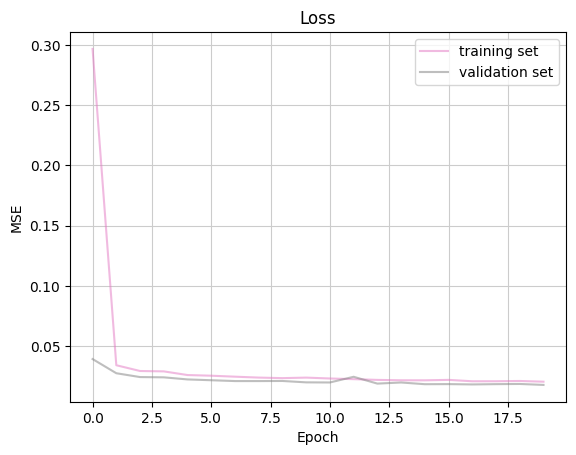

In [12]:
#.............................................
# PLOTTING HISTORY OF FIT
#.............................................

plt.plot(history.history['loss'],'C6',alpha=0.5,label='training set')
plt.plot(history.history['val_loss'],'C7',alpha=0.5,label='validation set')
plt.title('Loss' ) 
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.grid(color='0.8')  
plt.legend()
plt.show()

In [ ]:
# .............................................
# PLOTTING PREDICTIONS BASED ON THE UNET
# .............................................

# Generate predictions and reshape them to match the high-res shape
# Generate noise without the time dimension
noise_input = np.random.normal(0, 1, (Xtest.shape[0], Xtest.shape[2], Xtest.shape[3], Xtest.shape[4]))

# Generate predictions
test_predictions = model.predict([Xtest, noise_input])

print(test_predictions.shape)

213/213 [==============================] - 143s 672ms/step
(6805, 24, 26, 54, 1)


In [14]:
#save output to NC files to do analysis in R

import os
import numpy as np
from netCDF4 import Dataset

# Define your dimensions
time_dim = 24
lat_dim = 26
lon_dim = 54

# Latitude and longitude arrays (customize as needed)
latitudes = np.linspace(48.25, 48.25 + (lat_dim - 1) * 0.5, lat_dim)
longitudes = np.linspace(-120.75, -120.75 + (lon_dim - 1) * 0.5, lon_dim)

# Directory to save the files
output_dir = "nc_filesALL"
os.makedirs(output_dir, exist_ok=True)

# Loop through each of the 400 samples in test_predictions
for i in range(test_predictions.shape[0]):
    # File name
    file_name = os.path.join(output_dir, f"sample_{i+1}.nc")
    
    # Create the NetCDF file
    with Dataset(file_name, "w", format="NETCDF4") as ncfile:
        # Create dimensions
        ncfile.createDimension("time", time_dim)
        ncfile.createDimension("lat", lat_dim)
        ncfile.createDimension("lon", lon_dim)
        
        # Create variables
        times = ncfile.createVariable("time", "i4", ("time",))
        lats = ncfile.createVariable("lat", "f4", ("lat",))
        lons = ncfile.createVariable("lon", "f4", ("lon",))
        precipitation = ncfile.createVariable("precipitation", "f4", ("time", "lat", "lon"))
        
        # Add metadata (optional)
        ncfile.description = "Test predictions for precipitation downscaling"
        #ncfile.history = "Created on " + Dataset.date.today().strftime("%Y-%m-%d")
        lats.units = "degrees_north"
        lons.units = "degrees_east"
        precipitation.units = "mm/hr"  # Replace with actual units if different
        
        # Assign values to the variables
        times[:] = np.arange(time_dim)  # Replace with actual time values if needed
        lats[:] = latitudes
        lons[:] = longitudes
        precipitation[:, :, :] = test_predictions[i, :, :, :, 0]  # Extract the sample data
        
    print(f"Saved {file_name}")


Saved nc_filesALL\sample_1.nc
Saved nc_filesALL\sample_2.nc
Saved nc_filesALL\sample_3.nc
Saved nc_filesALL\sample_4.nc
Saved nc_filesALL\sample_5.nc
Saved nc_filesALL\sample_6.nc
Saved nc_filesALL\sample_7.nc
Saved nc_filesALL\sample_8.nc
Saved nc_filesALL\sample_9.nc
Saved nc_filesALL\sample_10.nc
Saved nc_filesALL\sample_11.nc
Saved nc_filesALL\sample_12.nc
Saved nc_filesALL\sample_13.nc
Saved nc_filesALL\sample_14.nc
Saved nc_filesALL\sample_15.nc
Saved nc_filesALL\sample_16.nc
Saved nc_filesALL\sample_17.nc
Saved nc_filesALL\sample_18.nc
Saved nc_filesALL\sample_19.nc
Saved nc_filesALL\sample_20.nc
Saved nc_filesALL\sample_21.nc
Saved nc_filesALL\sample_22.nc
Saved nc_filesALL\sample_23.nc
Saved nc_filesALL\sample_24.nc
Saved nc_filesALL\sample_25.nc
Saved nc_filesALL\sample_26.nc
Saved nc_filesALL\sample_27.nc
Saved nc_filesALL\sample_28.nc
Saved nc_filesALL\sample_29.nc
Saved nc_filesALL\sample_30.nc
Saved nc_filesALL\sample_31.nc
Saved nc_filesALL\sample_32.nc
Saved nc_filesALL

Plotting sample index: 87


C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


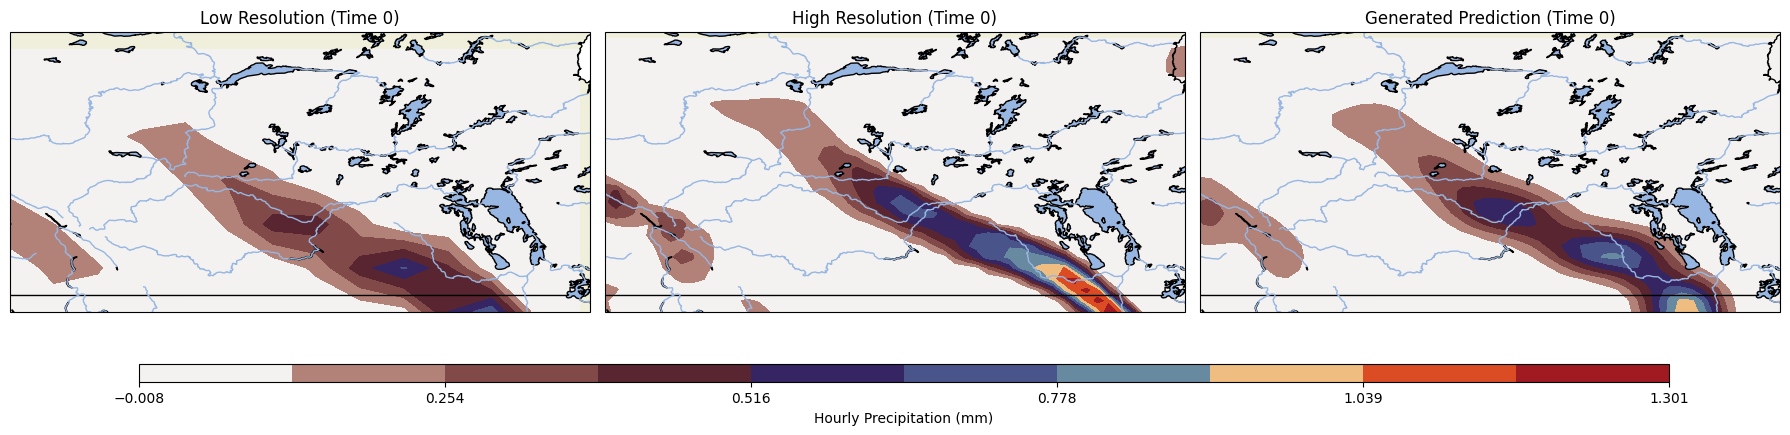

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


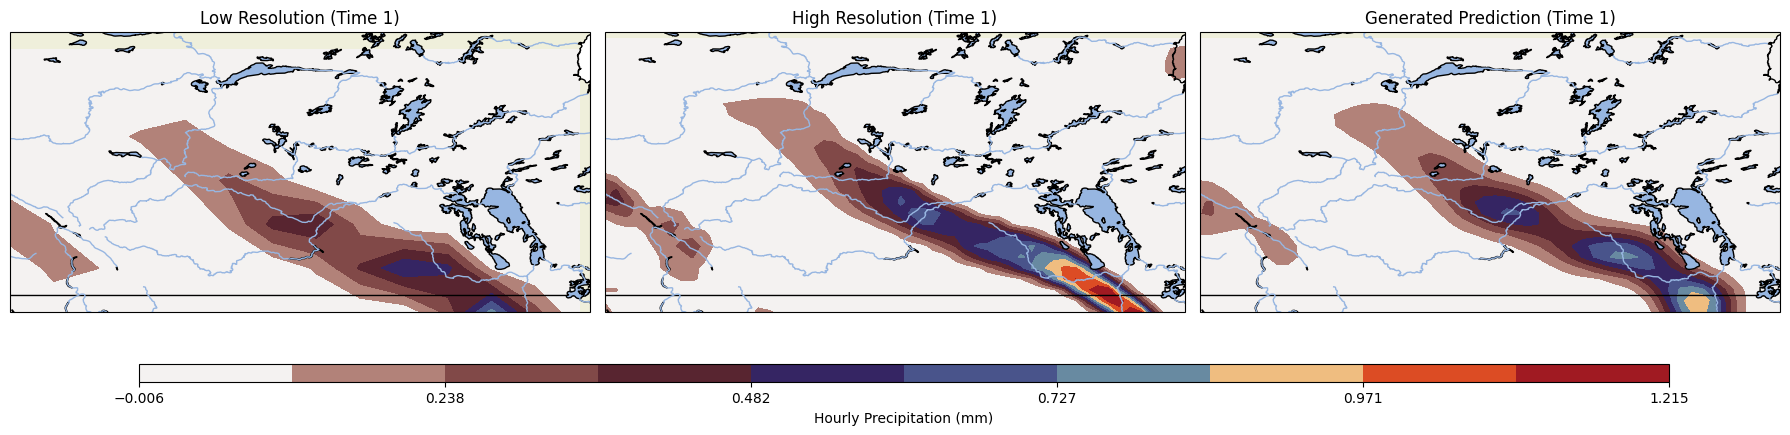

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


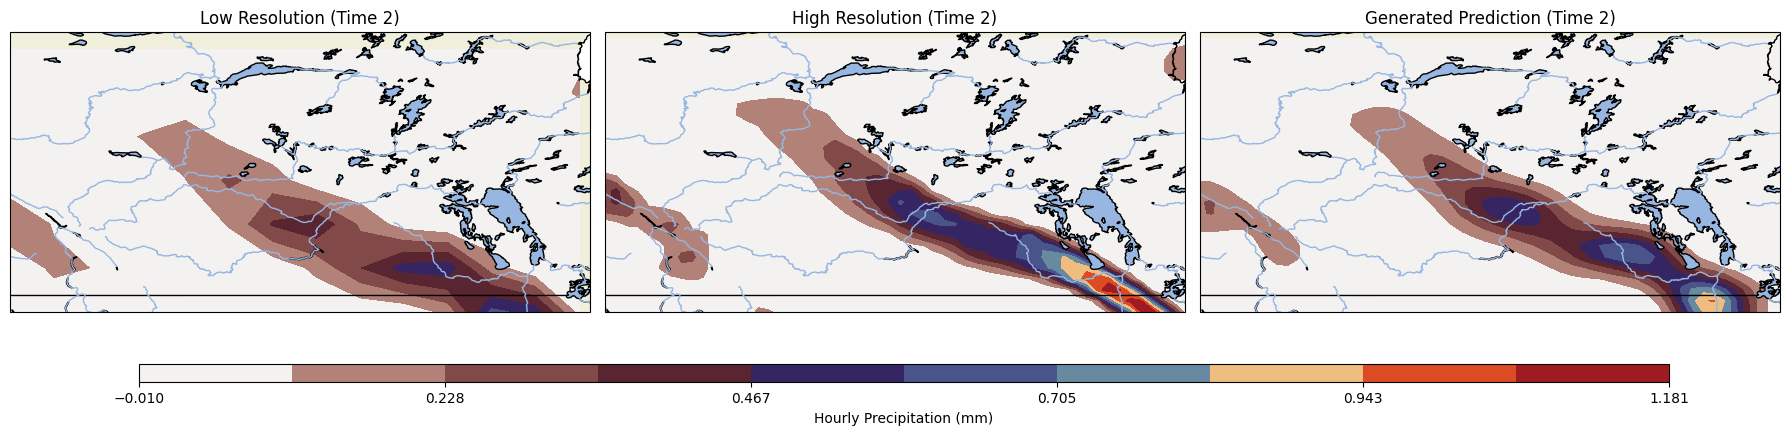

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


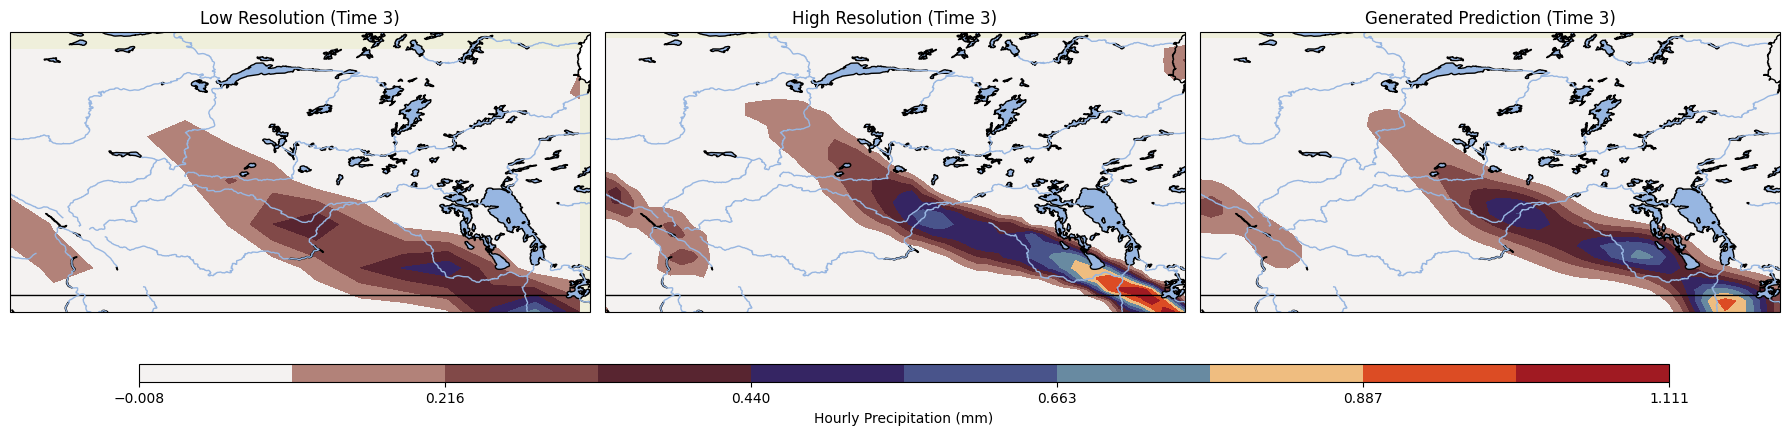

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


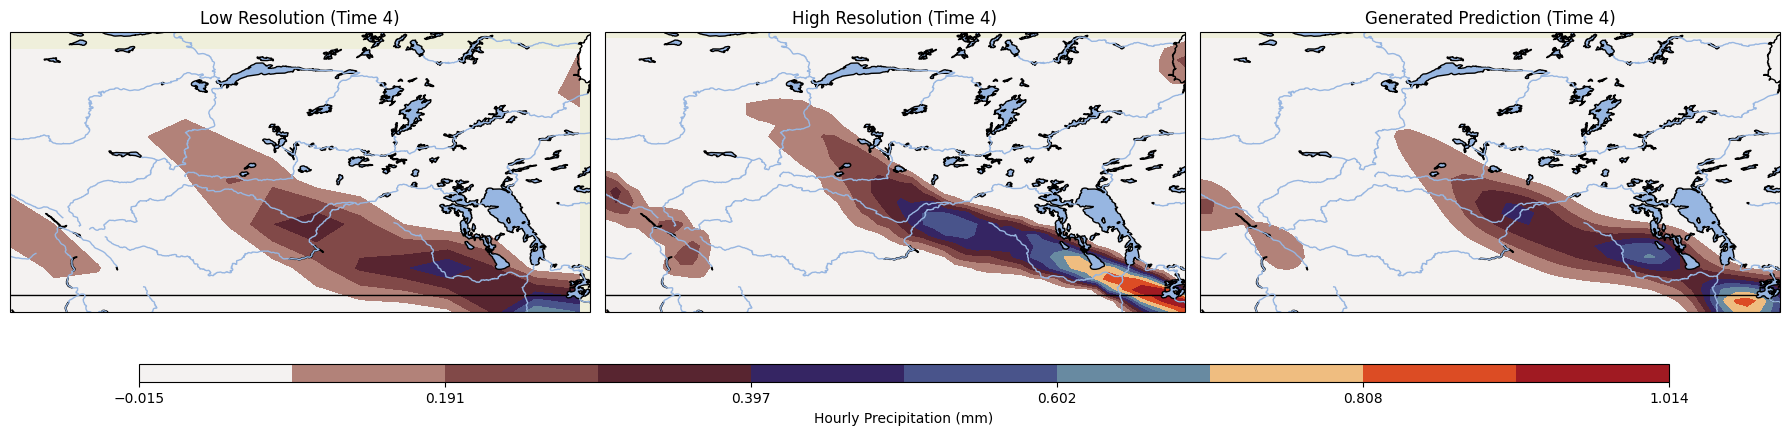

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


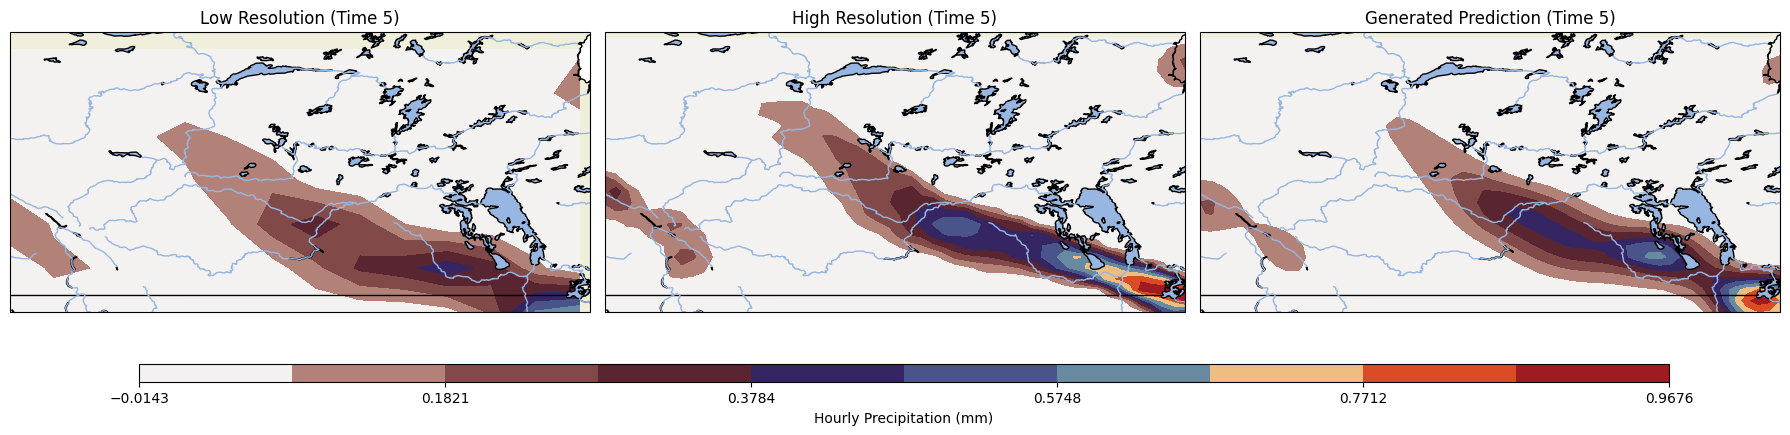

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


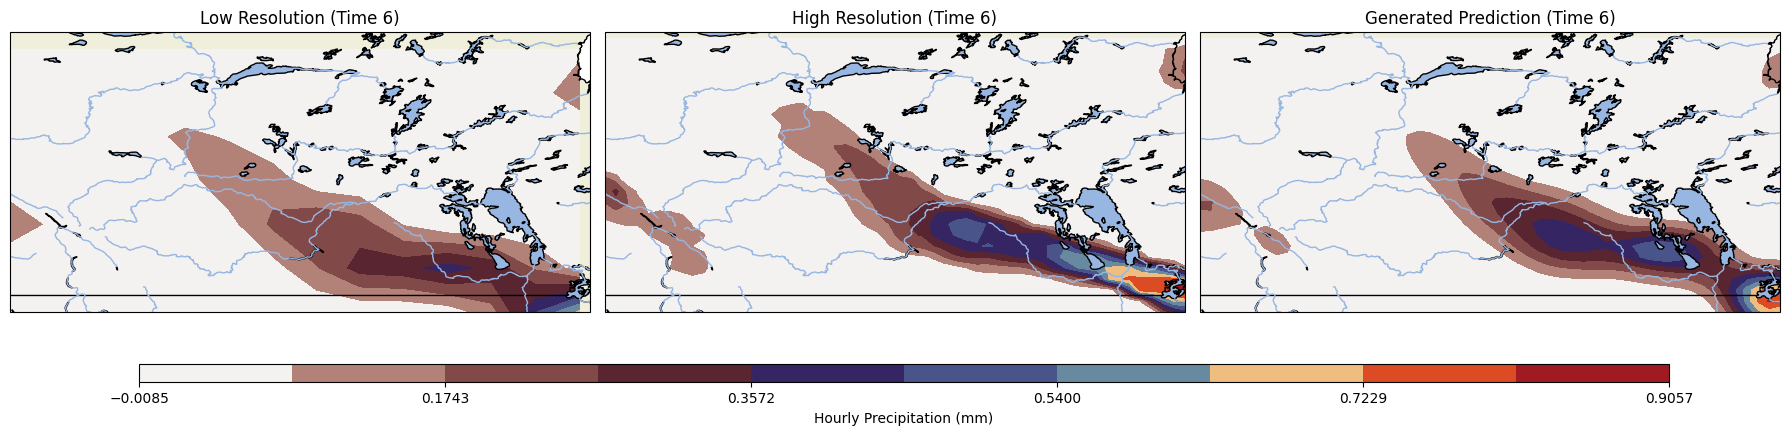

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


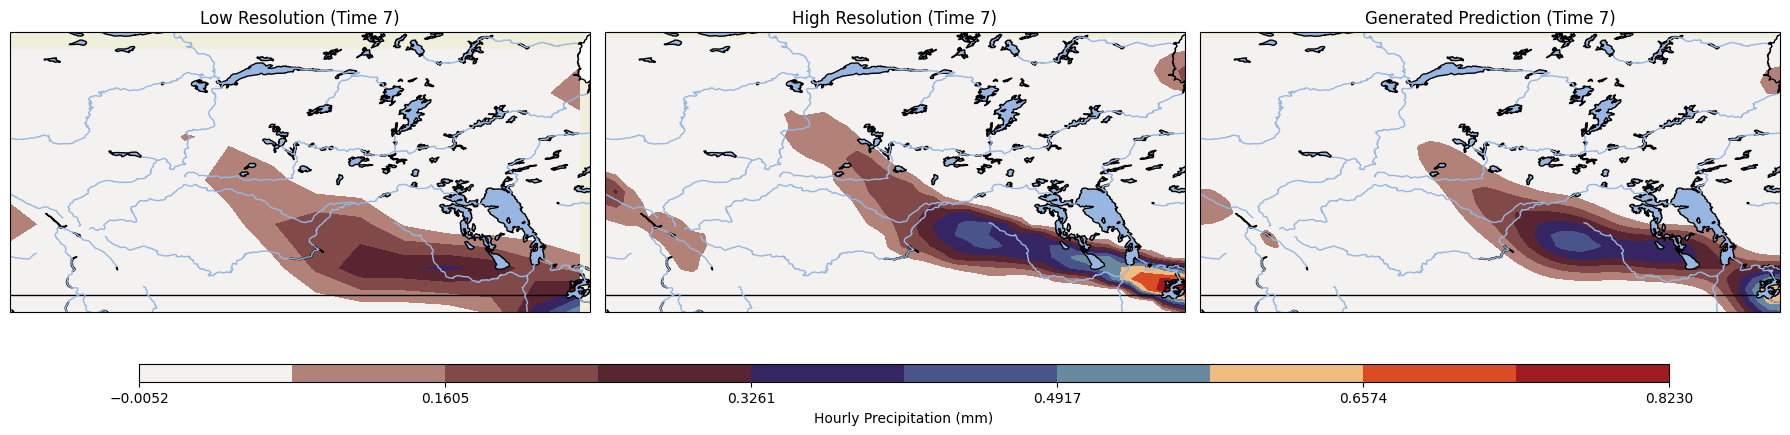

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


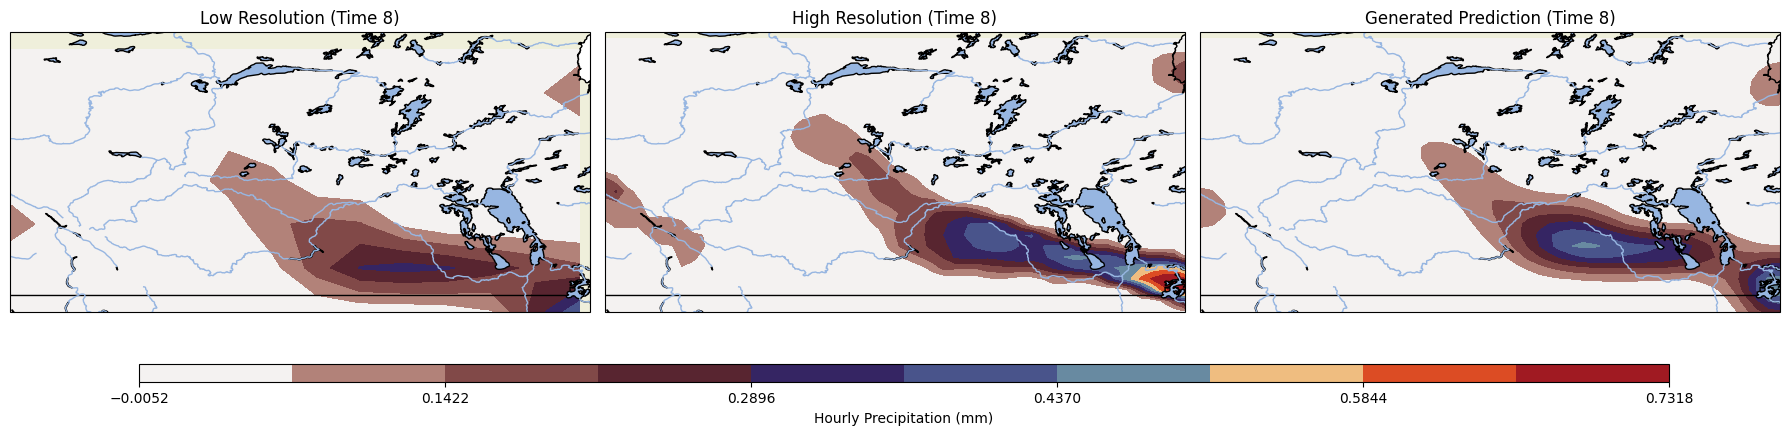

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


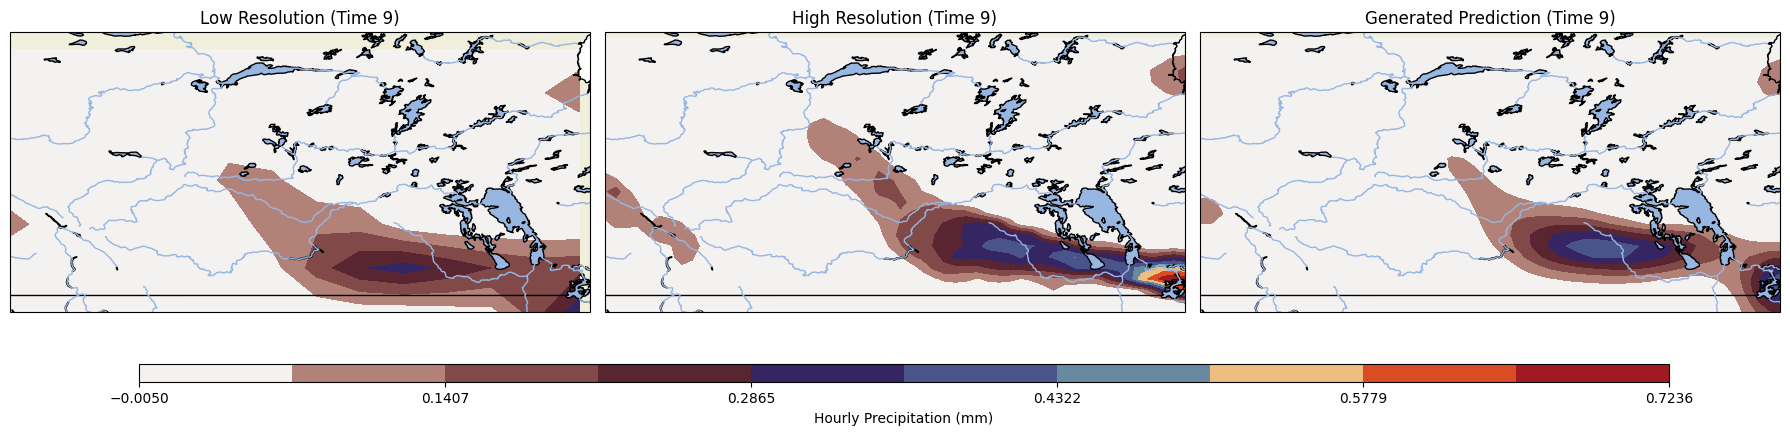

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


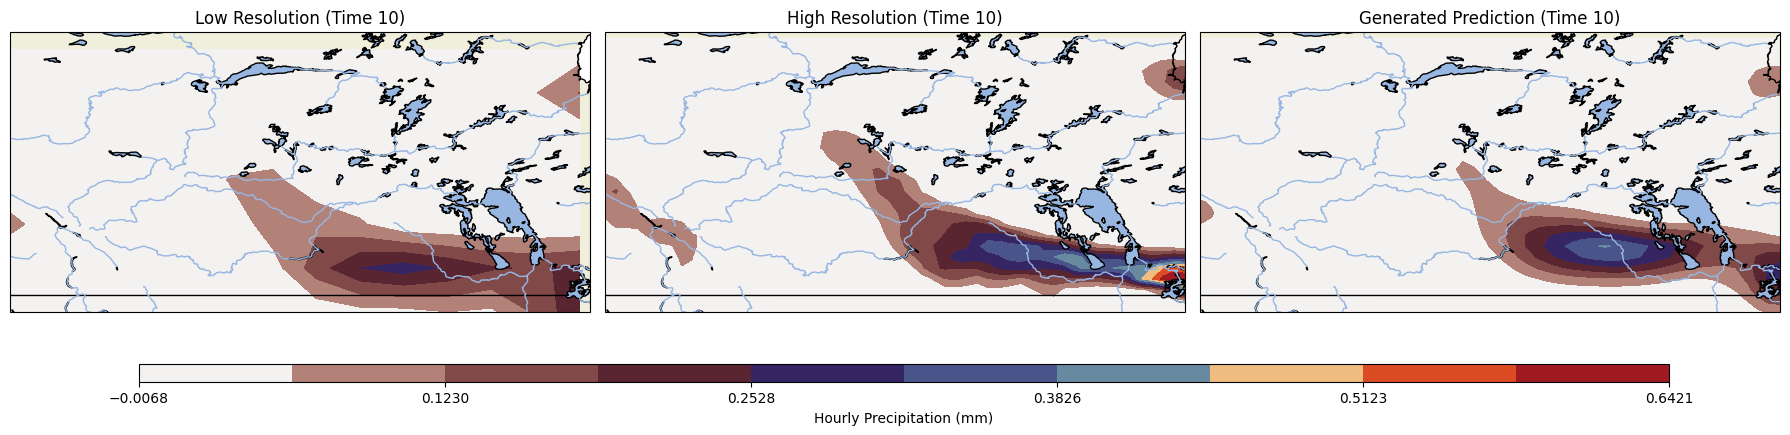

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


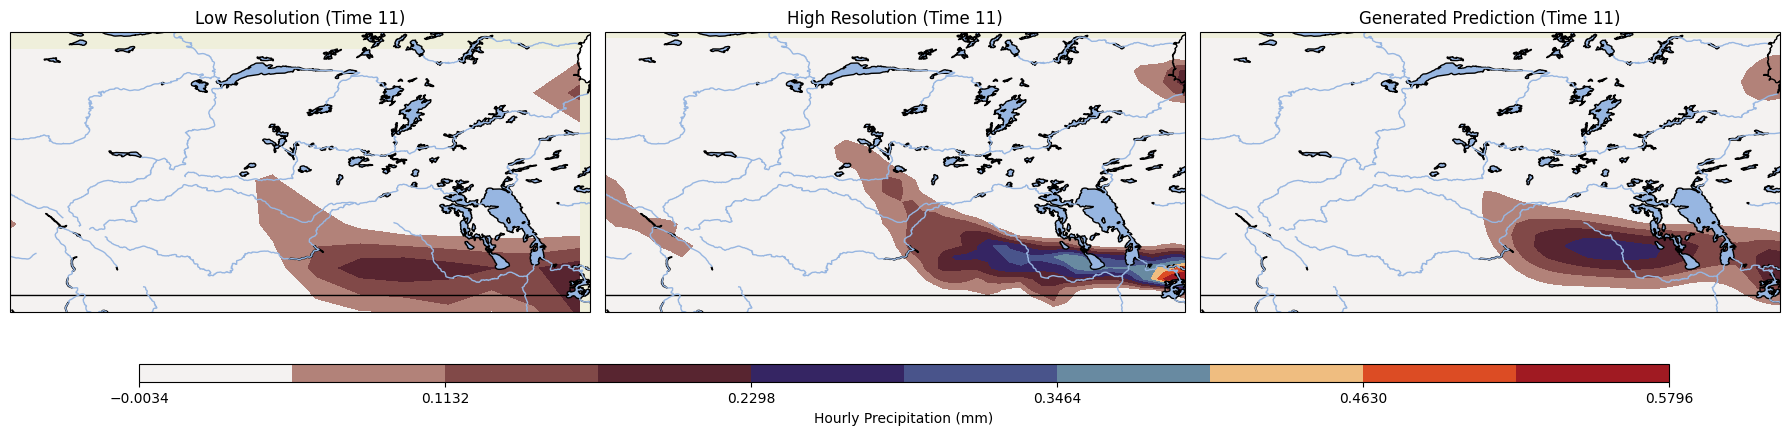

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


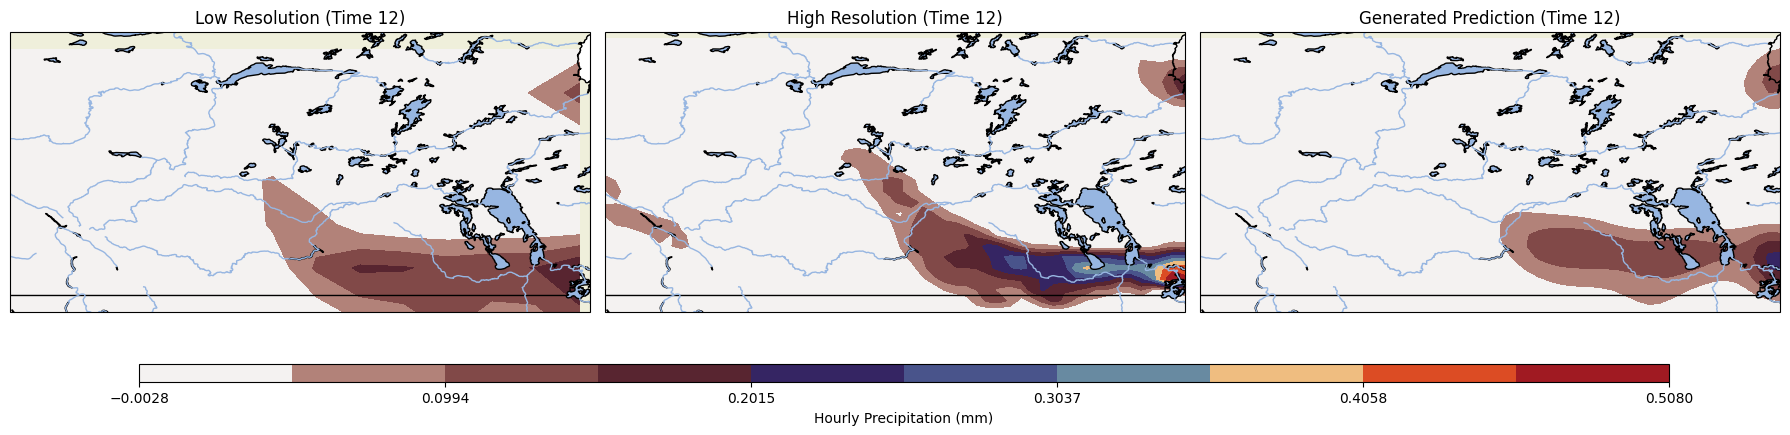

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


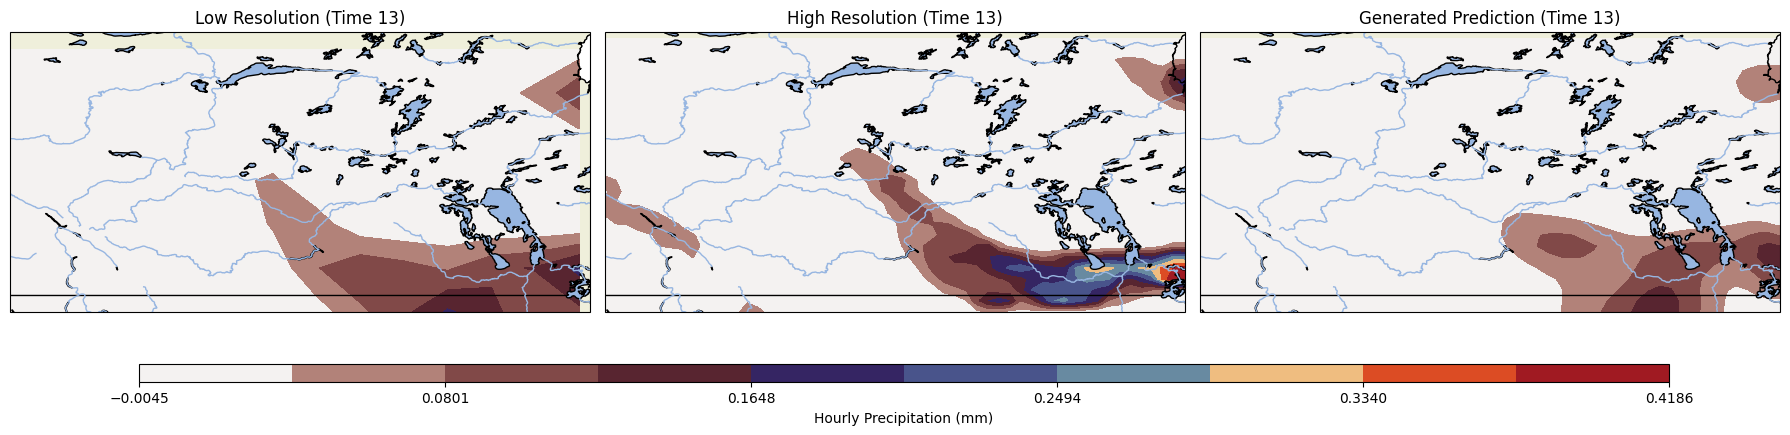

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


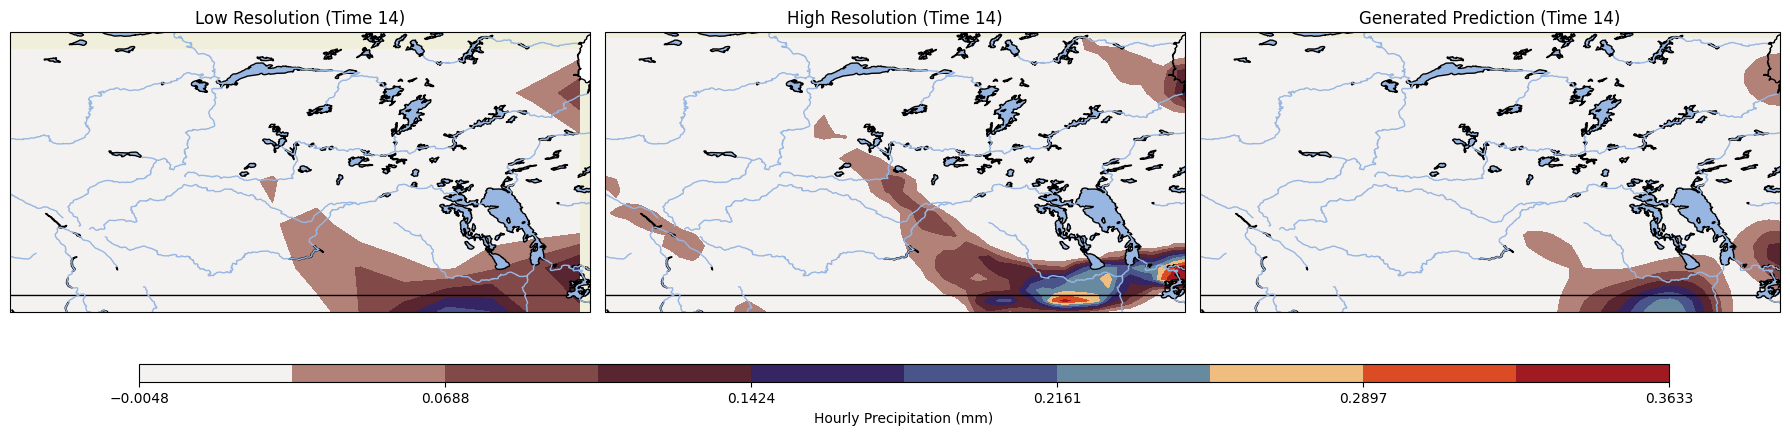

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


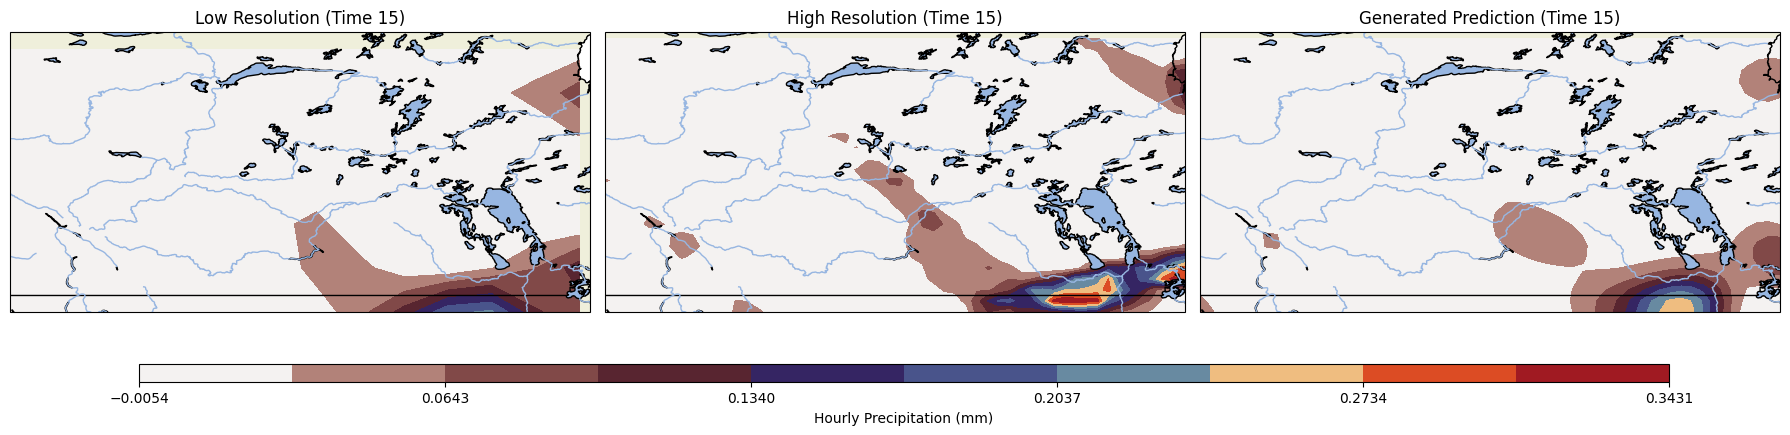

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


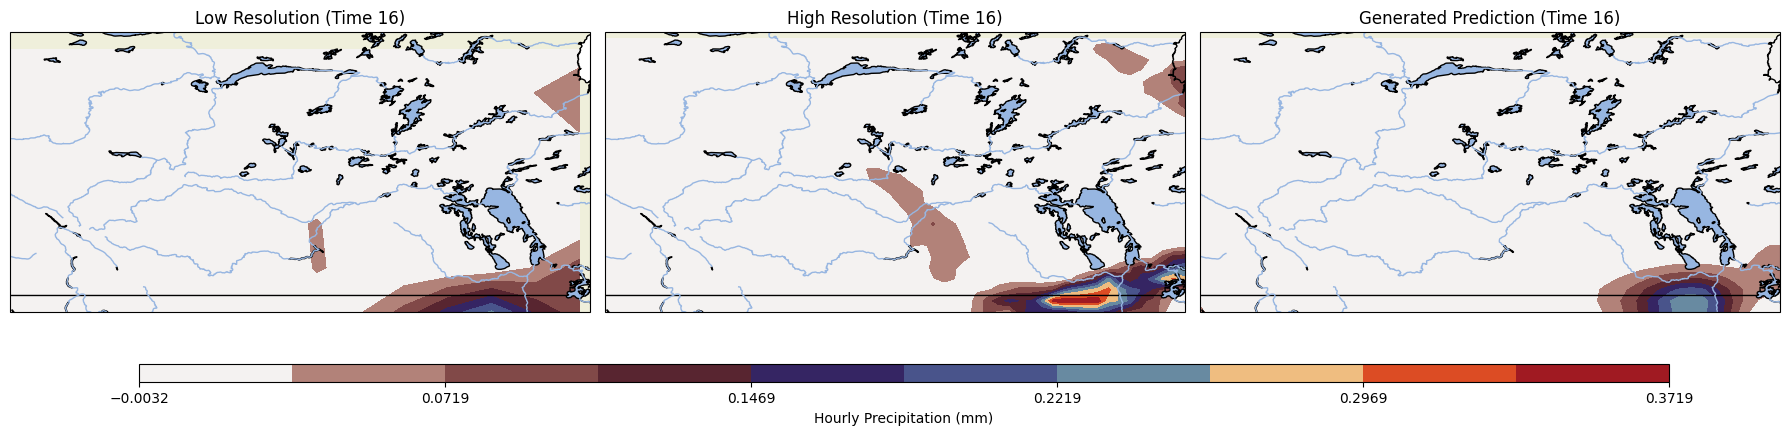

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


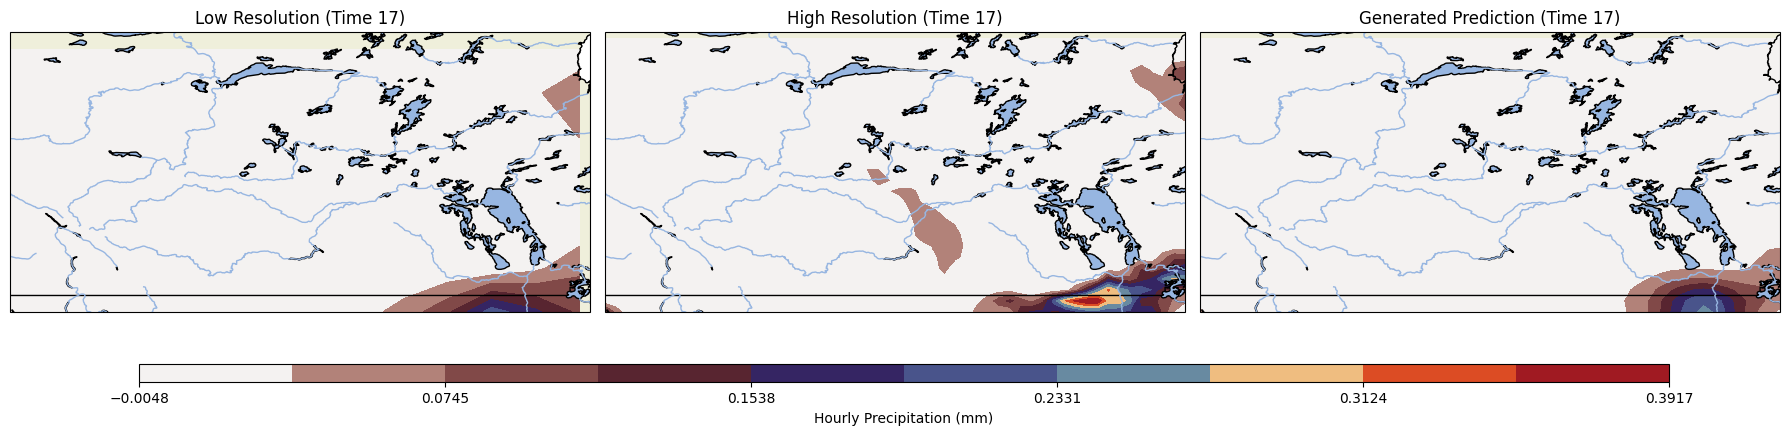

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


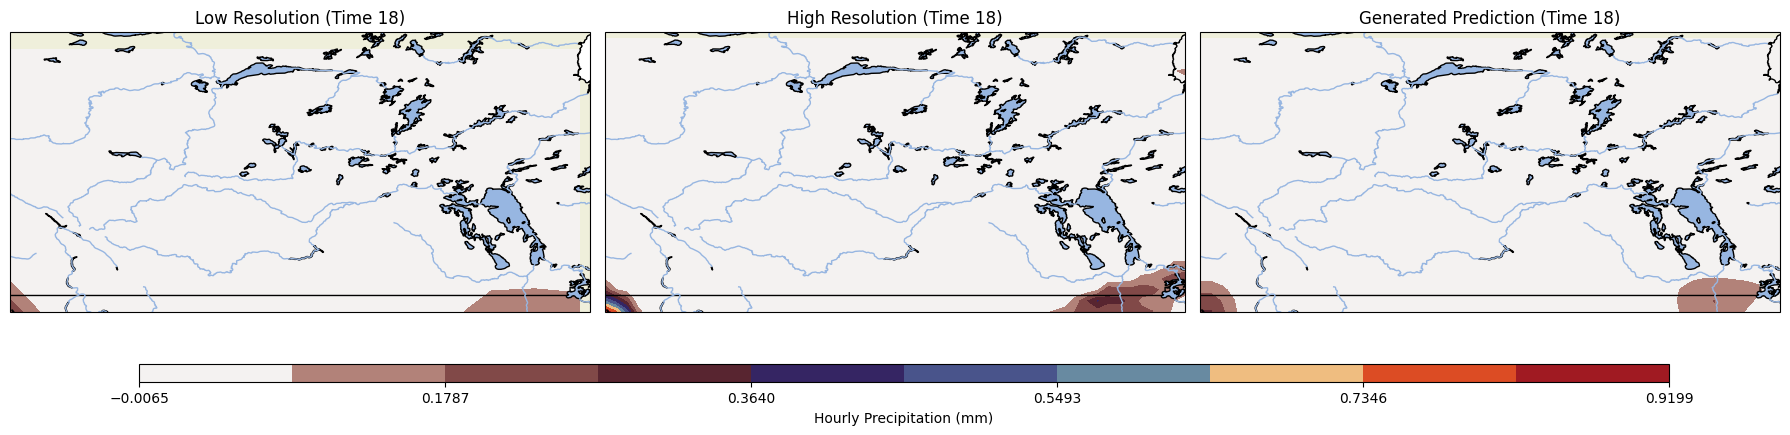

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


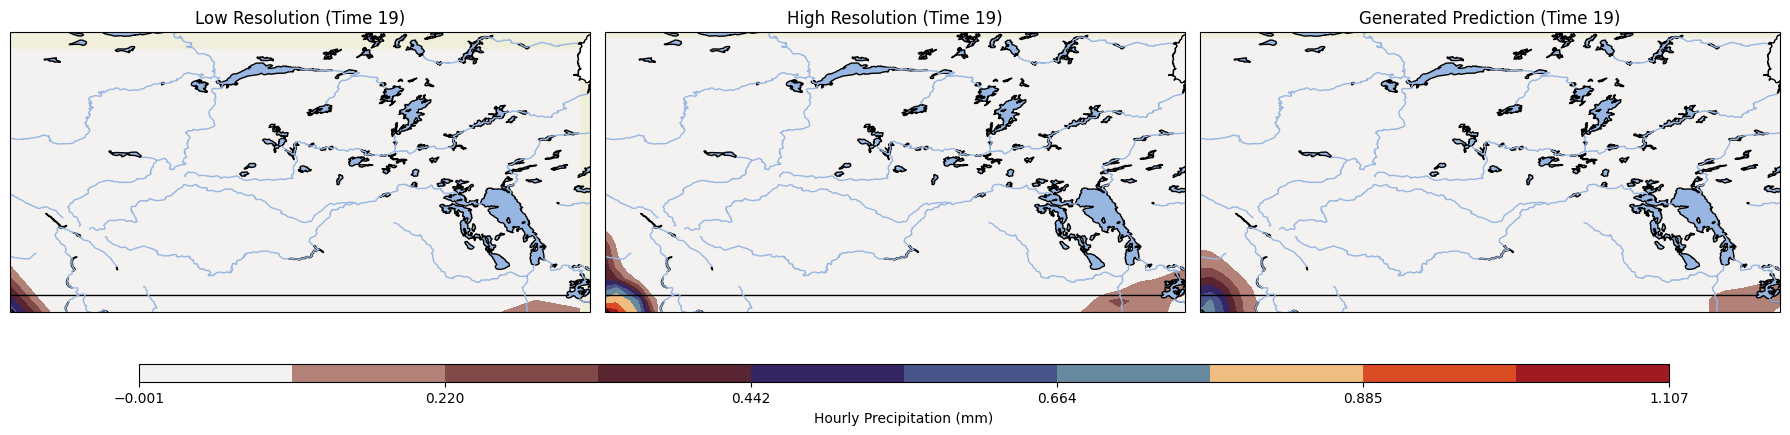

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


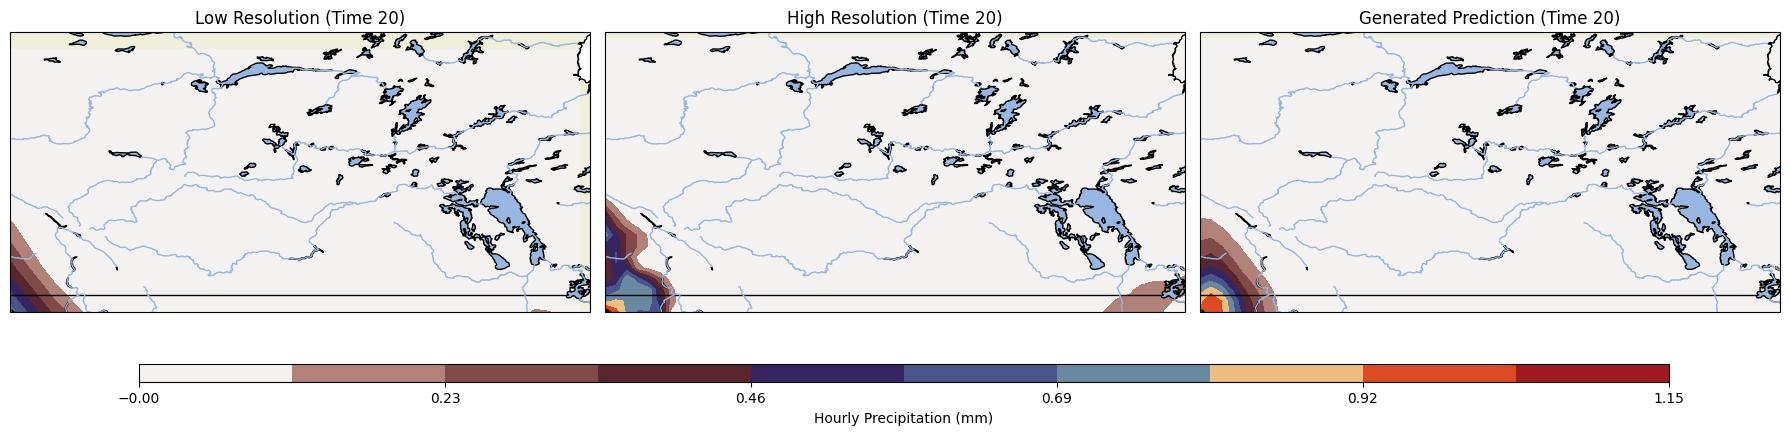

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


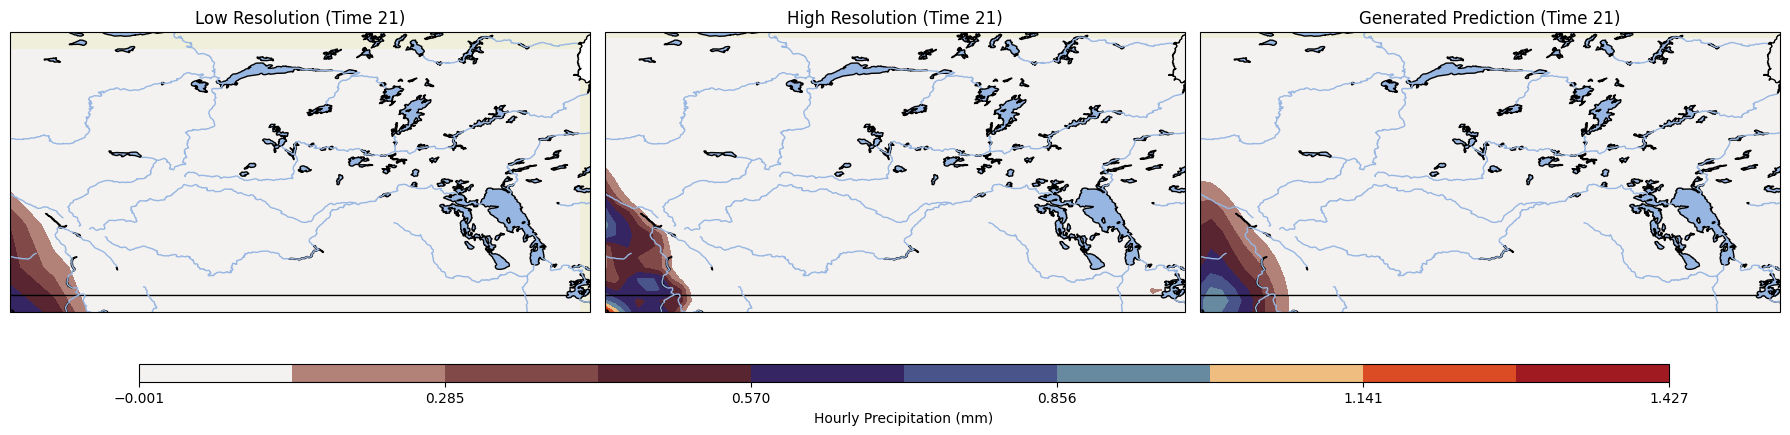

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


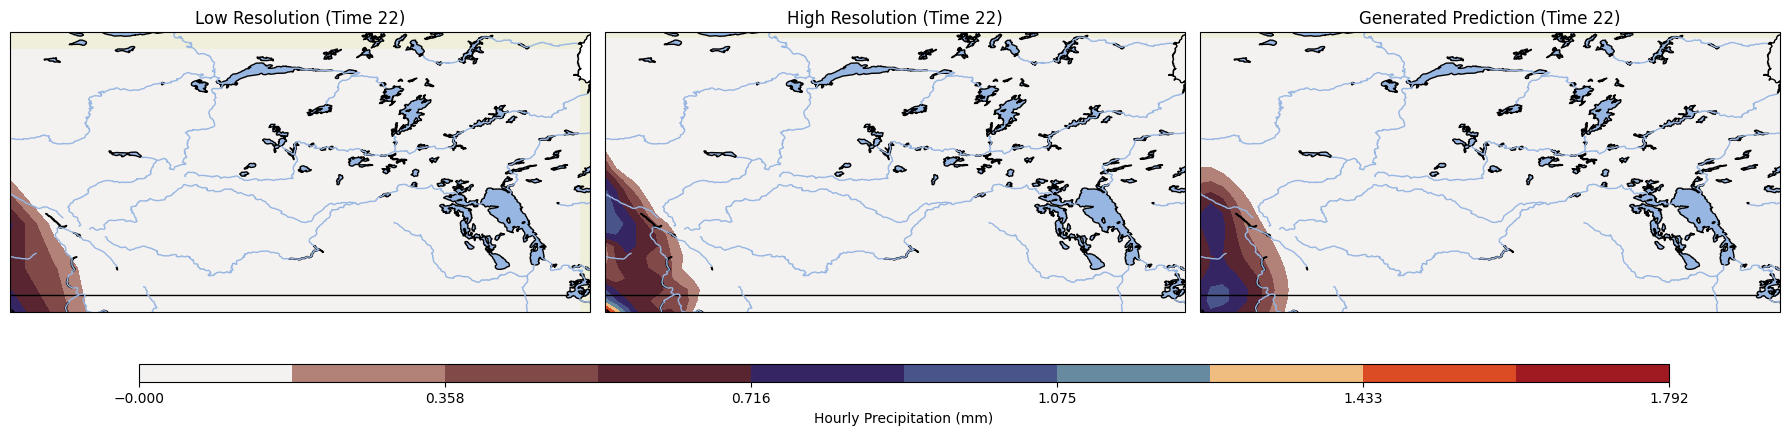

C:\Users\hebam\AppData\Local\Temp\ipykernel_28724\2836564073.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


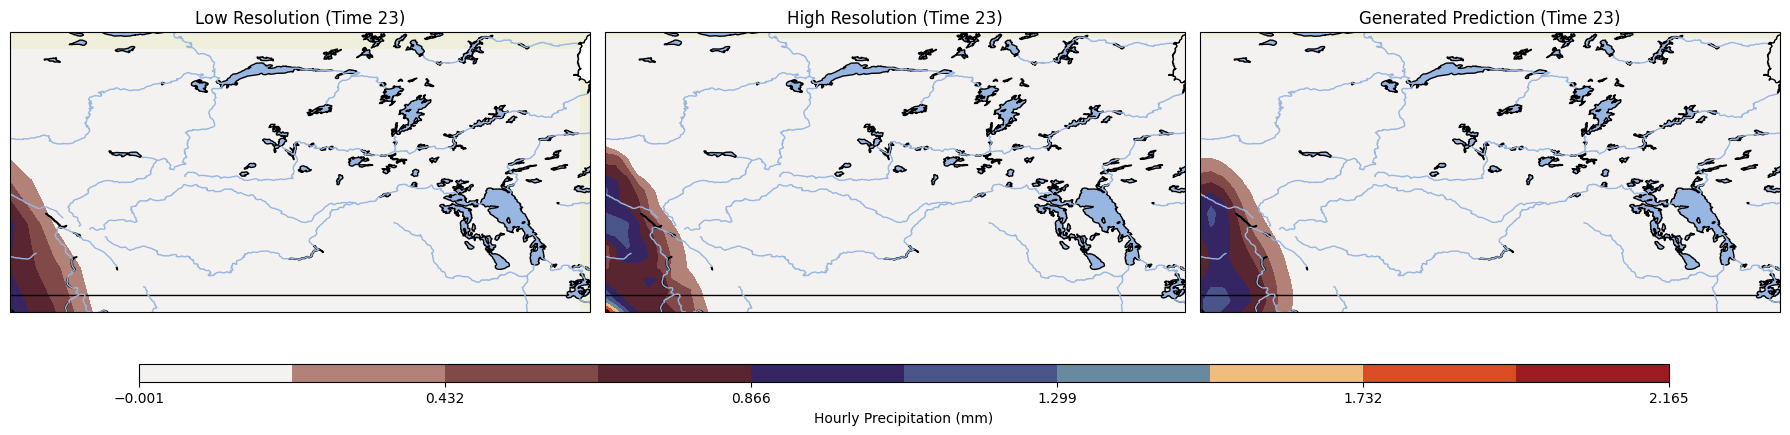

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Number of random samples to plot
num_random_samples = 1

# Generate 10 random sample indices
random_samples = np.random.choice(Xtest.shape[0], num_random_samples, replace=False)

for sample_idx in random_samples:
    print(f"Plotting sample index: {sample_idx}")
    
    # Loop over all time steps
    for time_index in range(Xtest.shape[1]):  # Assuming 24 time steps
        # Extract data for the selected sample and time step
        low_res = Xtest[sample_idx, time_index, :, :, 0]
        generated = test_predictions[sample_idx, time_index, :, :, 0]
        high_res = Ytest[sample_idx, time_index, :, :, 0]

        # Determine the global min and max for consistent color scaling
        vmin = min(low_res.min(), generated.min(), high_res.min())
        vmax = max(low_res.max(), generated.max(), high_res.max())
        levels = np.linspace(vmin, vmax, 11)

        # Latitude and longitude setup based on the high-resolution shape
        num_latitudes = high_res.shape[0]
        num_longitudes = high_res.shape[1]

        lats = np.linspace(48.25, 48.25 + (num_latitudes - 1) * 0.5, num_latitudes)
        lons = np.linspace(-120.75, -120.75 + (num_longitudes - 1) * 0.5, num_longitudes)

        lon_grid, lat_grid = np.meshgrid(lons, lats)

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        extent = [lons.min(), lons.max(), lats.min(), lats.max()]

        # Plot low-resolution input
        axs[0].set_extent(extent)
        axs[0].add_feature(cfeature.LAND)
        axs[0].add_feature(cfeature.COASTLINE)
        axs[0].add_feature(cfeature.BORDERS)
        axs[0].add_feature(cfeature.LAKES, edgecolor='black')
        axs[0].add_feature(cfeature.RIVERS)
        im0 = axs[0].contourf(lon_grid[::4, ::4], lat_grid[::4, ::4], low_res, levels=levels, cmap=custom_cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        axs[0].set_title(f'Low Resolution (Time {time_index})')

        # Plot high-resolution ground truth
        axs[1].set_extent(extent)
        axs[1].add_feature(cfeature.LAND)
        axs[1].add_feature(cfeature.COASTLINE)
        axs[1].add_feature(cfeature.BORDERS)
        axs[1].add_feature(cfeature.LAKES, edgecolor='black')
        axs[1].add_feature(cfeature.RIVERS)
        im1 = axs[1].contourf(lon_grid, lat_grid, high_res, levels=levels, cmap=custom_cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        axs[1].set_title(f'High Resolution (Time {time_index})')

        # Plot generated high-resolution prediction
        axs[2].set_extent(extent)
        axs[2].add_feature(cfeature.LAND)
        axs[2].add_feature(cfeature.COASTLINE)
        axs[2].add_feature(cfeature.BORDERS)
        axs[2].add_feature(cfeature.LAKES, edgecolor='black')
        axs[2].add_feature(cfeature.RIVERS)
        im2 = axs[2].contourf(lon_grid, lat_grid, generated, levels=levels, cmap=custom_cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        axs[2].set_title(f'Generated Prediction (Time {time_index})')

        # Add a shared colorbar
        cbar_ax = fig.add_axes([0.08, 0.15, 0.85, 0.03])  # [left, bottom, width, height]
        cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Hourly Precipitation (mm)')

        plt.tight_layout()
        plt.show()


In [ ]:

# Save the model

model.save("./Outputs/UNET.keras")

Now, the part of reading the saved model and generating prediction starts

In [7]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input
from tensorflow.keras.models import load_model

# Define the ReflectionPadding2D custom layer
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        super().__init__(**kwargs)
        self.padding = padding

    def call(self, inputs):
        return tf.pad(
            inputs,
            [[0, 0], [self.padding[0], self.padding[0]], [self.padding[1], self.padding[1]], [0, 0]],
            mode="REFLECT"
        )

# Define the residual_block function
def residual_block(x, filters, kernel_size=3, stride=1, padding='same', l2_reg=0.001):
    from tensorflow.keras import layers
    shortcut = x
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding,
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding=padding,
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding=padding,
                                 kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Define the leaky_relu_with_slope function
def leaky_relu_with_slope(x):
    from tensorflow.keras import layers
    return layers.LeakyReLU(alpha=0.2)(x)

# Load the model with all required custom objects
model = load_model(
    './Outputs/UNET.keras',
    custom_objects={
        'ReflectionPadding2D': ReflectionPadding2D,
        'residual_block': residual_block,
        'leaky_relu_with_slope': leaky_relu_with_slope
    },
    safe_mode=False
)

# Print the model summary
model.summary()

# Test the loaded model
noise_shape = Xtest.shape[:1] + Xtest.shape[2:]
random_noise = np.random.normal(0, 1, noise_shape)
print(random_noise.shape)

loss,acc = model.evaluate([Xtest,random_noise], Ytest)
print('Restored model, MSE: ', loss)
print('Restored model, MAE: ', acc)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 noise_input (InputLayer)    [(None, 7, 14, 1)]           0         []                            
                                                                                                  
 low_res_input (InputLayer)  [(None, 24, 7, 14, 1)]       0         []                            
                                                                                                  
 dense_1 (Dense)             (None, 7, 14, 16)            32        ['noise_input[0][0]']         
                                                                                                  
 time_distributed_34 (TimeD  (None, 24, 7, 14, 16)        160       ['low_res_input[0][0]']       
 istributed)                                                                              

In [9]:
# .............................................
# PLOTTING PREDICTIONS BASED ON THE UNET
# .............................................

# Generate predictions and reshape them to match the high-res shape
# Generate noise without the time dimension
noise_input = np.random.normal(0, 1, (Xtest.shape[0], Xtest.shape[2], Xtest.shape[3], Xtest.shape[4]))

# Generate predictions
test_predictions = model.predict([Xtest, noise_input])

print(test_predictions.shape)

213/213 [==============================] - 138s 646ms/step
(6805, 24, 26, 54, 1)


In [10]:
maxVal = max(Xtest[:, 0:23, :, :, 0].max(),test_predictions[:, 0:23, :, :, 0].max(), Ytest[:, 0:23, :, :, 0].max())
print(maxVal)

38.222786


In [12]:
#Global max and min for the testing set
vmin = 0.01
#vmax = max(Xtest[0:9, 0:23, :, :, 0].max(), test_predictions[0:9, 0:23, :, :, 0].max(), Ytest[0:9, 0:23, :, :, 0].max())
print(vmin)

vmax = 20.222847
print(vmax)


from matplotlib.colors import LogNorm
norm = LogNorm(vmin=vmin, vmax=vmax)

0.01
20.222847


In [13]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
from matplotlib.ticker import FuncFormatter, FixedLocator

# Create a directory to save the plots
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Define the latitude and longitude limits
specified_lat_min, specified_lat_max = 48, 60
specified_lon_min, specified_lon_max = -121, -95

# Latitude and longitude setup for high-resolution data
num_latitudes_high = Ytest.shape[2]
num_longitudes_high = Ytest.shape[3]
lats_high = np.linspace(48.25, 48.25 + (num_latitudes_high - 1) * 0.5, num_latitudes_high)
lons_high = np.linspace(-120.75, -120.75 + (num_longitudes_high - 1) * 0.5, num_longitudes_high)

# Edges for high-resolution data
lat_edges_high = np.linspace(lats_high.min() - 0.25, lats_high.max() + 0.25, len(lats_high) + 1)
lon_edges_high = np.linspace(lons_high.min() - 0.25, lons_high.max() + 0.25, len(lons_high) + 1)

# Latitude and longitude setup for low-resolution data
num_latitudes_low = Xtest.shape[2]
num_longitudes_low = Xtest.shape[3]
lats_low = np.linspace(48.25, 48.25 + (num_latitudes_low - 1) * 2, num_latitudes_low)
lons_low = np.linspace(-120.75, -120.75 + (num_longitudes_low - 1) * 2, num_longitudes_low)

# Edges for low-resolution data
lat_edges_low = np.linspace(lats_low.min() - 1, lats_low.max() + 1, len(lats_low) + 1)
lon_edges_low = np.linspace(lons_low.min() - 1, lons_low.max() + 1, len(lons_low) + 1)

# Process and save plots for the first 30 samples
for sample_idx in range(11):
    print(f"Processing sample index: {sample_idx}")

    for time_index in range(Ytest.shape[1]):  # Assuming 24 time steps
        # Extract data for the selected sample and time step
        low_res = Xtest[sample_idx, time_index, :, :, 0] 
        generated = test_predictions[sample_idx, time_index, :, :, 0]
        high_res = Ytest[sample_idx, time_index, :, :, 0]

        # Determine the global min and max for consistent color scaling
        #vmin = min(low_res.min(), generated.min(), high_res.min())
        #vmax = max(low_res.max(), generated.max(), high_res.max())
        levels = np.linspace(vmin, vmax, 11)

        # Plotting
        fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        extent = [specified_lon_min, specified_lon_max, specified_lat_min, specified_lat_max]

        # Plot low-resolution input (native resolution)
        im0 = axs[0].pcolormesh(lon_edges_low, lat_edges_low, low_res, transform=ccrs.PlateCarree(),
                                cmap=custom_cmap, shading='auto', norm = norm)
        axs[0].set_title(f"Low Resolution (Time {time_index})")
        axs[0].coastlines()
        axs[0].add_feature(cfeature.BORDERS, linestyle=':')
        axs[0].set_extent(extent, crs=ccrs.PlateCarree())
        axs[0].set_xticks(np.linspace(specified_lon_min, specified_lon_max, 5), crs=ccrs.PlateCarree())
        axs[0].set_yticks(np.linspace(specified_lat_min, specified_lat_max, 5), crs=ccrs.PlateCarree())
        axs[0].set_xlabel("Longitude")
        axs[0].set_ylabel("Latitude")

        # Plot high-resolution ground truth
        im1 = axs[1].pcolormesh(lon_edges_high, lat_edges_high, high_res, transform=ccrs.PlateCarree(),
                                cmap=custom_cmap, shading='auto', norm = norm)
        axs[1].set_title(f"High Resolution (Time {time_index})")
        axs[1].coastlines()
        axs[1].add_feature(cfeature.BORDERS, linestyle=':')
        axs[1].set_extent(extent, crs=ccrs.PlateCarree())
        axs[1].set_xticks(np.linspace(specified_lon_min, specified_lon_max, 5), crs=ccrs.PlateCarree())
        axs[1].set_yticks(np.linspace(specified_lat_min, specified_lat_max, 5), crs=ccrs.PlateCarree())
        axs[1].set_xlabel("Longitude")
        axs[1].set_ylabel("Latitude")

        # Plot generated high-resolution prediction
        im2 = axs[2].pcolormesh(lon_edges_high, lat_edges_high, generated, transform=ccrs.PlateCarree(),
                                cmap=custom_cmap, shading='auto', norm = norm)
        axs[2].set_title(f"Generator Only Prediction (Time {time_index})")
        axs[2].coastlines()
        axs[2].add_feature(cfeature.BORDERS, linestyle=':')
        axs[2].set_extent(extent, crs=ccrs.PlateCarree())
        axs[2].set_xticks(np.linspace(specified_lon_min, specified_lon_max, 5), crs=ccrs.PlateCarree())
        axs[2].set_yticks(np.linspace(specified_lat_min, specified_lat_max, 5), crs=ccrs.PlateCarree())
        axs[2].set_xlabel("Longitude")
        axs[2].set_ylabel("Latitude")

        # Add a common colorbar below the plots
        cbar_width = 0.6  # Adjust this value to control the width of the colorbar
        cbar_left = (1 - cbar_width) / 2  # Center the colorbar

        cbar_ax = fig.add_axes([cbar_left, 0.15, cbar_width, 0.02])  # Adjust the width and center it
        cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
        cbar.set_label("Hourly Precipitation (mm)")

        # Customize the colorbar ticks
        # Customize the colorbar tick labels to show decimal numbers
        def decimal_formatter(x, pos):
            return f"{x:.2f}"  # Format ticks as decimal with two decimal places
        
        desired_ticks = [0.01, 0.1, 1.0, 10.0, 20.0]  # Replace with your desired tick values

        # Apply the formatter
        cbar.set_ticks(desired_ticks)
        formatter = FuncFormatter(decimal_formatter)
        cbar.formatter = formatter

        # Optionally, set fixed tick locations (e.g., specific decimals)
        #ticks = np.logspace(vmin, vmax, num=6)  # Adjust `num` for more ticks
        #cbar.set_ticks(ticks)

        cbar.update_ticks()  # Update the colorbar with new tick formatting

        # Save the plot to a file
        output_file = os.path.join(output_dir, f"sample_{sample_idx}_time_{time_index}.png")
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.close(fig)

    print(f"Sample {sample_idx} processed and saved.")


Processing sample index: 0
Sample 0 processed and saved.
Processing sample index: 1
Sample 1 processed and saved.
Processing sample index: 2
Sample 2 processed and saved.
Processing sample index: 3
Sample 3 processed and saved.
Processing sample index: 4
Sample 4 processed and saved.
Processing sample index: 5
Sample 5 processed and saved.
Processing sample index: 6
Sample 6 processed and saved.
Processing sample index: 7
Sample 7 processed and saved.
Processing sample index: 8
Sample 8 processed and saved.
Processing sample index: 9
Sample 9 processed and saved.
Processing sample index: 10
Sample 10 processed and saved.
